# Confirmation Bias Project
## Behavioural analyses
#### Experiment 1

We recommend to run this script in Jupyter Notebook. It is possible to not visualize some plots in JupyterLab

##### Import important functions and libraries

In [1]:
import os, glob
import numpy as np
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import scipy
import scipy.stats as stats
from scipy import signal
import seaborn as sns
from statsmodels.formula.api import ols
import statsmodels.formula.api as smf
from statsmodels.stats.anova import AnovaRM
import pingouin as pg
from plotly.subplots import make_subplots
from statsmodels.stats.multicomp import (pairwise_tukeyhsd, MultiComparison)
from matplotlib.lines import Line2D
import statsmodels as sms
#import ptitprince as pt
pd.options.display.max_columns = None # display all the columns in pandas dataframe
import plotly.graph_objects as go
import plotly.express as px

##### Important functions

In [2]:
def RT_filter(x, sd): 
    # this function was used to filter those trials with a RT that are above X standard deviation from the mean
    rt_mean = x['RT'].mean()
    up_lim = rt_mean + sd * x['RT'].std()
    x = x.loc[(x['RT'] < up_lim) & (x['RT'] > 0), : ]
    return x #the same dataframe with RT filtered

def log_reg_fit(x, f): # this function was used to calculate the log linear regression between two vectors
    reg = smf.glm(formula = f, data = x, family=sm.families.Binomial()).fit()
    params = reg.params
    PSE = - reg.params.Intercept/reg.params[1]
    # concatenating parameters
    out = pd.DataFrame({'intercept':[params[0]] , 'weight':[params[1]],'PSE': PSE})
    return out #intercept + weight

def z_RT(x):
    # this function was used to calculate the z score of the RT values from a dataframe 
    rt_mean = x['RT'].mean()
    rt_sd   = x['RT'].std()
    x['RTz'] = (x['RT']- rt_mean)/rt_sd
    x['1/RTz']= 1/x['RT']
    rt_mean1  = x['1/RTz'].mean()
    rt_sd1    = x['1/RTz'].std()
    x['1/RTz']=(x['1/RTz']- rt_mean1)/rt_sd1
    return x

def z_DV(x):
    # this function was used to calculate the z score of the DV values from a dataframe 
    dv_mean = x['DV'].mean()
    dv_sd   = x['DV'].std()
    x['DVz'] = (x['DV']- dv_mean)/dv_sd
    return x

def cartesian(arrays, out=None):
    """
    Examples
    --------
    >>> cartesian(([1, 2, 3], [4, 5], [6, 7]))
    """

    arrays = [np.asarray(x) for x in arrays]
    dtype = arrays[0].dtype

    n = np.prod([x.size for x in arrays])
    if out is None:
        out = np.zeros([n, len(arrays)], dtype=dtype)

    #m = n / arrays[0].size
    m = int(n / arrays[0].size) 
    out[:,0] = np.repeat(arrays[0], m)
    if arrays[1:]:
        cartesian(arrays[1:], out=out[0:m, 1:])
        for j in range(1, arrays[0].size):
        #for j in xrange(1, arrays[0].size):
            out[j*m:(j+1)*m, 1:] = out[0:m, 1:]
    return out

### Data & variables

In [3]:
# CAUTION !! 
# Change the current path to the folder where you stored the experimental results 

# results_path = 'C:/Users/Angel/Dropbox/ConfBiasProject/Analyses/results' #windows/main
# results_path = '/Users/alex/OneDrive - Universitat de Barcelona/Projects/Condcision/Behav_data/FirstExperiment' #mac
results_path = '/home/freeman/Insync/alexisperez@ub.edu/OneDrive Biz/Projects/Condcision/Behav_data/FirstExperiment' #
#results_path = '/Users/alex/OneDrive - Universitat de Barcelona/Projects/Condcision/Behav_data/FirstExperiment' 
os.chdir(results_path) # change the current working directory to the results path 

all_df = pd.DataFrame([]) # concatenate all behav subject data together
ddata = pd.DataFrame([]) # concatenate here behav data + dv + orientations


nsubj = 0 # initialize subjects counter

for file in glob.glob("*.psydat"): 
    subjdata = pd.DataFrame([]) # initialize individual subject data variable container
    pfile =  open(os.path.join(results_path, file),"rb")
    nsubj = nsubj + 1
    dat = pickle.load(pfile)
    for block in dat['main_exp']['Exp_blocks']:
        dvdata = pd.DataFrame(signal.sawtooth(4 * (block['trial_orientations']), 0.5),columns=['d1','d2','d3','d4','d5','d6'])
        ddata = pd.concat([block['data'], dvdata, block['trial_orientations']], axis = 1)
        subjdata = pd.concat([subjdata, ddata], axis = 0)
    
    subjdata.insert(0, 'npar', nsubj)
    
    all_df = pd.concat([all_df, subjdata], axis = 0) #concatenate each new subject

all_df.head(10)


,npar,subj,nblock,ntrial,nrep,cond,DV,resp,r_map,correct,RT,d1,d2,d3,d4,d5,d6,o1,o2,o3,o4,o5,o6
0,1,p14,0,0,0,-1,-0.38,m,45,1,2.511,-0.581859,-0.985758,0.611403,-0.523808,-0.383752,-0.337915,1.735,3.136,0.938,0.187,0.242,0.260
1,1,p14,0,0,1,-1,-0.38,z,0,1,2.051,-0.581859,-0.985758,0.611403,-0.523808,-0.383752,-0.337915,1.735,3.136,0.938,0.187,0.242,0.260
2,1,p14,0,0,2,-1,-0.38,m,0,-1,2.242,-0.581859,-0.985758,0.611403,-0.523808,-0.383752,-0.337915,1.735,3.136,0.938,0.187,0.242,0.260
3,1,p14,0,1,0,-1,-0.28,m,45,1,2.213,0.319595,0.563020,-0.220777,-0.691357,-0.825330,-0.858434,2.089,0.957,0.306,1.692,3.073,3.086
4,1,p14,0,1,1,-1,-0.28,z,0,1,1.528,0.319595,0.563020,-0.220777,-0.691357,-0.825330,-0.858434,2.089,0.957,0.306,1.692,3.073,3.086
5,1,p14,0,1,2,-1,-0.28,m,45,1,1.269,0.319595,0.563020,-0.220777,-0.691357,-0.825330,-0.858434,2.089,0.957,0.306,1.692,3.073,3.086
6,1,p14,0,2,0,1,0.18,z,45,1,1.332,0.507516,-0.006873,-0.019606,0.209578,0.245747,0.168834,0.592,0.390,0.385,0.475,2.060,0.459
7,1,p14,0,2,1,1,0.18,z,45,1,1.426,0.507516,-0.006873,-0.019606,0.209578,0.245747,0.168834,0.592,0.390,0.385,0.475,2.060,0.459
8,1,p14,0,2,2,1,0.18,z,45,1,1.664,0.507516,-0.006873,-0.019606,0.209578,0.245747,0.168834,0.592,0.390,0.385,0.475,2.060,0.459
9,1,p14,0,3,0,-1,-0.08,m,0,-1,4.060,-0.016540,0.007368,0.316011,-0.947043,0.117904,0.091921,1.957,2.746,1.054,1.550,0.439,1.142


### Dataframe experiment 1: coding important variables

In [4]:
df = all_df.copy() # copy tge variable

# relabeling some variables
df['cond'] = all_df['cond'].replace([-1], 0)
df['correct'] = all_df['correct'].replace([-1], 0)

df.insert(5, 'cond-1', 0)    # 0 = previous Diag / 1 = previous Card
df['cond-1'] = df['cond'].shift(1, fill_value  = 0)

# Inserting deci variable
df.insert(9, 'deci', 0)
crit1 = (df['cond']  > 0) & (df['correct'] == 1);    # 0 = diagonal       
crit2 = (df['cond']  < 0) & (df['correct'] == 0);            
crit3 = (df['cond'] == 0) & (df['correct'] == 0);
df.loc[crit1 | crit2 | crit3, 'deci'] = 1 

# Inserting the new necessary columns coding trials properly
df.insert(9, 'deci-1', 0)    # 0 = previous Diag / 1 = previous Card
df.insert(11, 'corr-1', 0) # O = incorrect / 1 = correct
df.insert(7, 'rDV', 0) # rDV (real Decision Variable)
df.insert(10, 'deci-2', 0)    # 0 = 2 previous Diag / 1 = previous Card

# Recoding variables
df['deci-1'] = df['deci'].shift(1, fill_value  = 0) # deci in trial n-1
df['deci-2'] = df['deci-1'].shift(1, fill_value  = 0) # deci in trial n-2
df['corr-1'] = df['correct'].shift(1, fill_value  = 0) # correct in trial n-1


df['rDV'] = np.mean(df.iloc[:,17:23], axis = 1) # average DV
df.head(50)

,npar,subj,nblock,ntrial,nrep,cond-1,cond,rDV,DV,resp,deci-2,deci-1,deci,corr-1,r_map,correct,RT,d1,d2,d3,d4,d5,d6,o1,o2,o3,o4,o5,o6
0,1,p14,0,0,0,0,0,-0.366948,-0.38,m,0,0,0,0,45,1,2.511,-0.581859,-0.985758,0.611403,-0.523808,-0.383752,-0.337915,1.735,3.136,0.938,0.187,0.242,0.260
1,1,p14,0,0,1,0,0,-0.366948,-0.38,z,0,0,0,1,0,1,2.051,-0.581859,-0.985758,0.611403,-0.523808,-0.383752,-0.337915,1.735,3.136,0.938,0.187,0.242,0.260
2,1,p14,0,0,2,0,0,-0.366948,-0.38,m,0,0,1,1,0,0,2.242,-0.581859,-0.985758,0.611403,-0.523808,-0.383752,-0.337915,1.735,3.136,0.938,0.187,0.242,0.260
3,1,p14,0,1,0,0,0,-0.285548,-0.28,m,0,1,0,0,45,1,2.213,0.319595,0.563020,-0.220777,-0.691357,-0.825330,-0.858434,2.089,0.957,0.306,1.692,3.073,3.086
4,1,p14,0,1,1,0,0,-0.285548,-0.28,z,1,0,0,1,0,1,1.528,0.319595,0.563020,-0.220777,-0.691357,-0.825330,-0.858434,2.089,0.957,0.306,1.692,3.073,3.086
5,1,p14,0,1,2,0,0,-0.285548,-0.28,m,0,0,0,1,45,1,1.269,0.319595,0.563020,-0.220777,-0.691357,-0.825330,-0.858434,2.089,0.957,0.306,1.692,3.073,3.086
6,1,p14,0,2,0,0,1,0.184199,0.18,z,0,0,1,1,45,1,1.332,0.507516,-0.006873,-0.019606,0.209578,0.245747,0.168834,0.592,0.390,0.385,0.475,2.060,0.459
7,1,p14,0,2,1,1,1,0.184199,0.18,z,0,1,1,1,45,1,1.426,0.507516,-0.006873,-0.019606,0.209578,0.245747,0.168834,0.592,0.390,0.385,0.475,2.060,0.459
8,1,p14,0,2,2,1,1,0.184199,0.18,z,1,1,1,1,45,1,1.664,0.507516,-0.006873,-0.019606,0.209578,0.245747,0.168834,0.592,0.390,0.385,0.475,2.060,0.459
9,1,p14,0,3,0,1,0,-0.071730,-0.08,m,1,1,1,1,0,0,4.060,-0.016540,0.007368,0.316011,-0.947043,0.117904,0.091921,1.957,2.746,1.054,1.550,0.439,1.142


### Reaction Times 
##### Filter those responses with RTs larger than 4 sd

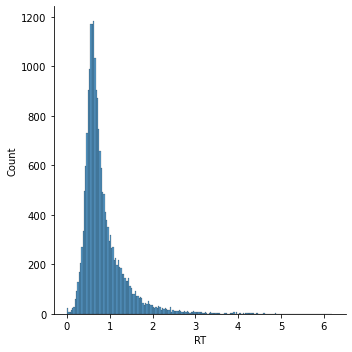

In [5]:
# RTs after apply filter
df = df.groupby(['npar'], group_keys = False).apply(RT_filter, sd = 4)
sns.displot(df.RT)

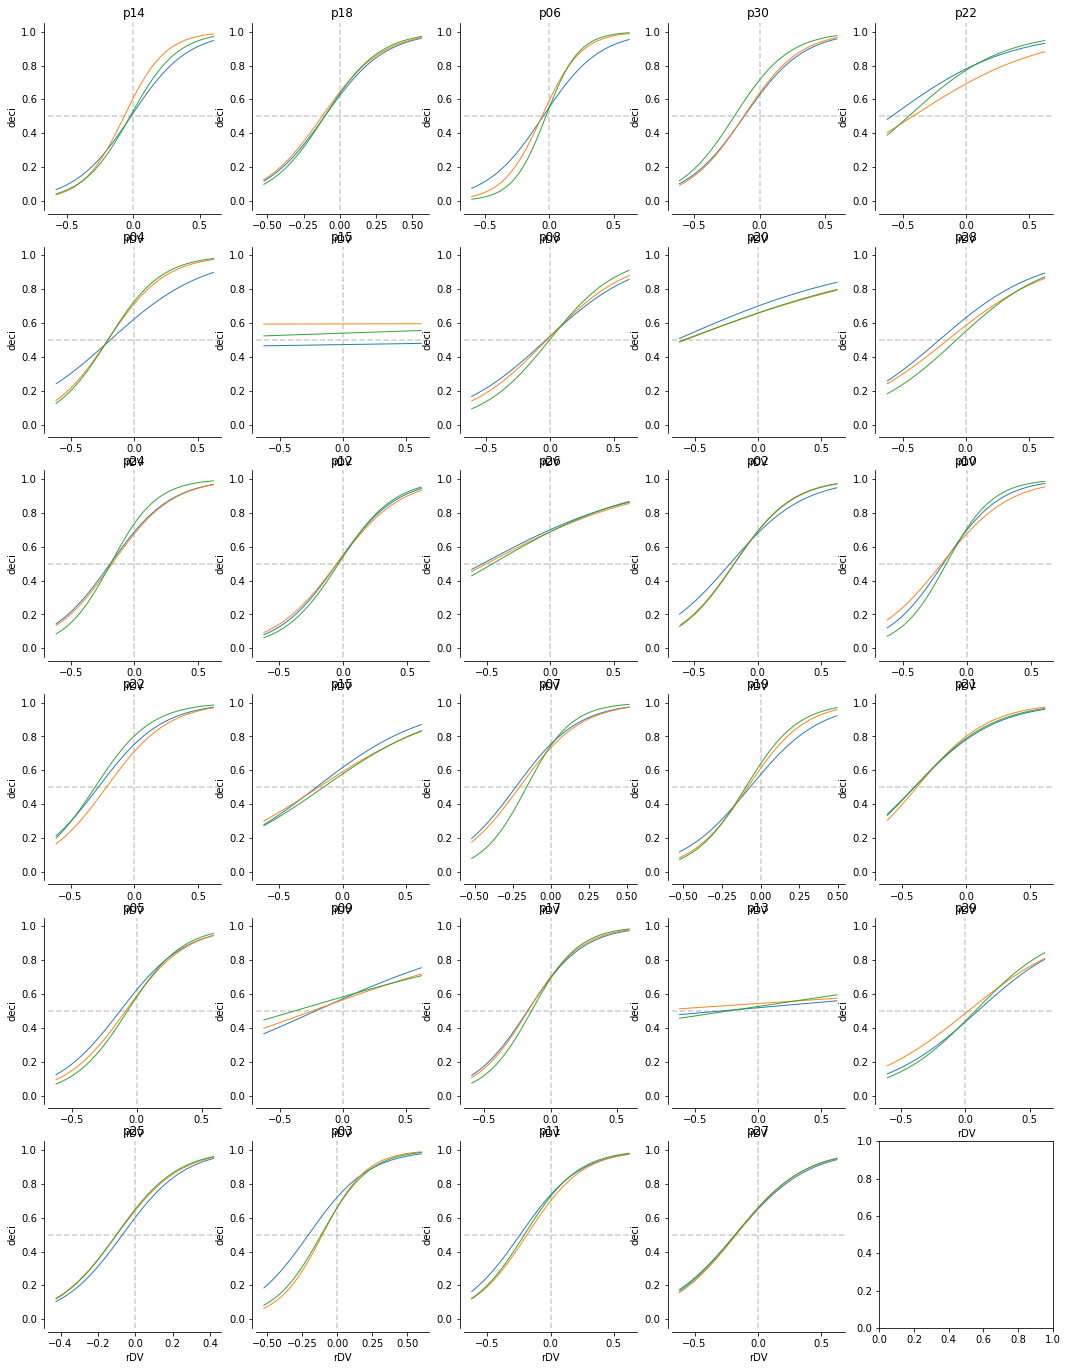

In [6]:
nprows = 6 
npcols = 5

nrep_labels = np.unique(df.nrep) #nrep
npar_labels = np.unique(df.npar) #npar


fig, axes = plt.subplots(nprows, npcols, figsize=(18, 24))
#fig.tight_layout() # improving the space
p = cartesian((np.arange(0,nprows), np.arange(0,npcols)))

for i in npar_labels: #for loop to compute the average by each participant
    df2 = df.loc[df.npar == i,:]
    axes[p[i-1,0],p[i-1,1]].axvline(0, ls='--', color= 'black', alpha=0.2)
    axes[p[i-1,0],p[i-1,1]].axhline(0.5, ls='--', color= 'black', alpha=0.2)
    axes[p[i-1,0],p[i-1,1]].title.set_text(df2.iloc[0,1])
    sns.despine(ax=axes[p[i-1,0],p[i-1,1]],offset=4); # , trim=True
    for cell in nrep_labels:
            #sns.set_palette(mycol)
            sns.regplot(ax=axes[p[i-1,0],p[i-1,1]],x="rDV", y="deci",  data=df2.loc[df2.nrep == cell,:],
               logistic=True, y_jitter=0, scatter_kws={'alpha':0}, ci=True, n_boot=1,  label=cell,  truncate=True, 
                             line_kws ={'alpha':0.95, 'lw':1}); #mean all subject
    

#plt.ylabel('p(diagonal)', fontsize = 25, labelpad=20); plt.yticks(np.arange(0, 1.1, step=0.25), fontsize = 15) 
#axes[1].plt.xlabel('Decision Variable', fontdict={'size':25}, labelpad=20); 
#axes[1].plt.xticks(np.arange(-0.6, 0.61, step=0.3), fontsize = 15)

### Removing bad participants

In [7]:
formula = "deci ~ rDV"
log_par = df.groupby(['subj']).apply(log_reg_fit, formula)
log_par.reset_index(inplace = True)
log_par.head(39)
# here it seems that visual inspection shows that p13 and p15 were pretty bad

,subj,level_1,intercept,weight,PSE
0,p02,0,0.779587,4.020736,-0.193892
1,p03,0,0.759427,5.549574,-0.136844
2,p04,0,0.751524,3.783163,-0.198650
3,p05,0,0.402188,4.297827,-0.093579
4,p06,0,0.261211,6.068092,-0.043047
5,p07,0,1.059913,5.425560,-0.195355
6,p08,0,0.061193,3.158280,-0.019375
7,p09,0,0.295322,1.098939,-0.268734
8,p10,0,0.812910,4.547120,-0.178775
9,p11,0,0.942535,4.484762,-0.210164


In [9]:
df = df.loc[df.subj != 'p13',:] #removed because sd lower than 2 sd from mean
df = df.loc[df.subj != 'p15',:]     #removed because not followed the instructions: counted
df.reset_index(drop=True, inplace=True) # reset the row indexes of the pandas dataframe

##### Dataset with good participants

In [10]:
# Final n after removing bad participants:
print("Subjects in the final dataset = " + str(len(np.unique(df.npar))))
print(np.unique(df.npar)) # those are the particiapnts that remain in the data anlyses

Subjects in the final dataset = 26
[ 1  2  3  4  5  6  8  9 10 11 12 13 14 15 16 18 19 20 21 22 23 25 26 27
 28 29]


In [11]:
estimations = (np.max(np.unique(df.ntrial)) + 1)* (np.max(np.unique(df.nblock)) + 1)
print("number of trials by participant was " + str(estimations))

number of trials by participant was 240


###### The original dataset was transformed to long format to perform some of the necessary analyses
 - It allows to perform reverse correlation analyses
 - We inserted new variables to this dataset

In [12]:
df.head(10)

,npar,subj,nblock,ntrial,nrep,cond-1,cond,rDV,DV,resp,deci-2,deci-1,deci,corr-1,r_map,correct,RT,d1,d2,d3,d4,d5,d6,o1,o2,o3,o4,o5,o6
0,1,p14,0,0,0,0,0,-0.366948,-0.38,m,0,0,0,0,45,1,2.511,-0.581859,-0.985758,0.611403,-0.523808,-0.383752,-0.337915,1.735,3.136,0.938,0.187,0.242,0.260
1,1,p14,0,0,1,0,0,-0.366948,-0.38,z,0,0,0,1,0,1,2.051,-0.581859,-0.985758,0.611403,-0.523808,-0.383752,-0.337915,1.735,3.136,0.938,0.187,0.242,0.260
2,1,p14,0,0,2,0,0,-0.366948,-0.38,m,0,0,1,1,0,0,2.242,-0.581859,-0.985758,0.611403,-0.523808,-0.383752,-0.337915,1.735,3.136,0.938,0.187,0.242,0.260
3,1,p14,0,1,0,0,0,-0.285548,-0.28,m,0,1,0,0,45,1,2.213,0.319595,0.563020,-0.220777,-0.691357,-0.825330,-0.858434,2.089,0.957,0.306,1.692,3.073,3.086
4,1,p14,0,1,1,0,0,-0.285548,-0.28,z,1,0,0,1,0,1,1.528,0.319595,0.563020,-0.220777,-0.691357,-0.825330,-0.858434,2.089,0.957,0.306,1.692,3.073,3.086
5,1,p14,0,1,2,0,0,-0.285548,-0.28,m,0,0,0,1,45,1,1.269,0.319595,0.563020,-0.220777,-0.691357,-0.825330,-0.858434,2.089,0.957,0.306,1.692,3.073,3.086
6,1,p14,0,2,0,0,1,0.184199,0.18,z,0,0,1,1,45,1,1.332,0.507516,-0.006873,-0.019606,0.209578,0.245747,0.168834,0.592,0.390,0.385,0.475,2.060,0.459
7,1,p14,0,2,1,1,1,0.184199,0.18,z,0,1,1,1,45,1,1.426,0.507516,-0.006873,-0.019606,0.209578,0.245747,0.168834,0.592,0.390,0.385,0.475,2.060,0.459
8,1,p14,0,2,2,1,1,0.184199,0.18,z,1,1,1,1,45,1,1.664,0.507516,-0.006873,-0.019606,0.209578,0.245747,0.168834,0.592,0.390,0.385,0.475,2.060,0.459
9,1,p14,0,3,1,0,0,-0.071730,-0.08,z,1,1,0,0,0,1,1.020,-0.016540,0.007368,0.316011,-0.947043,0.117904,0.091921,1.957,2.746,1.054,1.550,0.439,1.142


In [13]:
# df to long format
dflong = pd.melt(df, id_vars=['npar','subj','nblock','ntrial','nrep','cond-1','cond', 'deci-2','deci-1','deci', 'corr-1', 'correct','RT'], value_vars=['d1', 'd2', 'd3', 'd4', 'd5', 'd6'])
dflong.shape
dflong.rename(columns={'variable' : "stim", 'value' : 'dv'}, inplace=True)

out = pd.melt(df, id_vars=['npar','subj','nblock','ntrial','nrep','cond-1','cond', 'deci-2','deci-1','deci', 'corr-1', 'correct','RT'], value_vars=['o1', 'o2', 'o3', 'o4', 'o5', 'o6'])
dflong['orient'] = out.value
dflong.orient = np.rad2deg(dflong.orient) # transform to degrees
del out

dflong = dflong.sort_values(['nblock','npar','ntrial','nrep',],ascending=[True,True,True,True]) # reorder variables
dflong.reset_index(drop=True, inplace=True)
dflong.insert(5, "stim_cond", "D")
dflong.loc[(dflong.dv < 0), "stim_cond"]  = "C"


dflong.insert(7, 'cong_deci', "I") # if stim is congruent with previous repetition decosion category
# an stimuli is expected when the previous dv and previous deci were the same (i.e.DV==D & pre_deci == D)
dflong.loc[(dflong['deci-1'] == 0) & (dflong.stim_cond == 'C') | (dflong['deci-1'] == 1) & (dflong.stim_cond == 'D'), "cong_deci"]  = "C"



dflong.insert(8, 'cong_stim', 'I') # if stim is congruent with previous repetition mean category
dflong.loc[(dflong['cond-1'] == 0) & (dflong.stim_cond == 'C') | (dflong['cond-1'] == 'D') & (dflong.stim_cond == 'D'), 'cong_stim'] = 'C'

# relabeling variables
#dflong["cond-1"].replace({0: "C", 1: "D"}, inplace=True)
#dflong["deci"].replace({0: "C", 1: "D"}, inplace=True)
#dflong["deci-1"].replace({0: "C", 1: "D"}, inplace=True)
#dflong["deci-2"].replace({0: "C", 1: "D"}, inplace=True)


dflong['ov'] = signal.sawtooth(2*np.deg2rad(dflong.orient), 0.5) # orientation variable (here I define an ov to make stimuli that differ by less of 45 degrees or more than 135 as similar)
# plt.scatter(dflong.orient,dflong['ov']) # see here



dflong.head(10)


,npar,subj,nblock,ntrial,nrep,stim_cond,cond-1,cong_deci,cong_stim,cond,deci-2,deci-1,deci,corr-1,correct,RT,stim,dv,orient,ov
0,1,p14,0,0,0,C,0,C,C,0,0,0,0,0,1,2.511,d1,-0.581859,99.408177,0.790929
1,1,p14,0,0,0,C,0,C,C,0,0,0,0,0,1,2.511,d2,-0.985758,179.679565,-0.992879
2,1,p14,0,0,0,D,0,I,I,0,0,0,0,0,1,2.511,d3,0.611403,53.743441,0.194299
3,1,p14,0,0,0,C,0,C,C,0,0,0,0,0,1,2.511,d4,-0.523808,10.714311,-0.761904
4,1,p14,0,0,0,C,0,C,C,0,0,0,0,0,1,2.511,d5,-0.383752,13.865579,-0.691876
5,1,p14,0,0,0,C,0,C,C,0,0,0,0,0,1,2.511,d6,-0.337915,14.896903,-0.668958
6,1,p14,0,0,1,C,0,C,C,0,0,0,0,1,1,2.051,d1,-0.581859,99.408177,0.790929
7,1,p14,0,0,1,C,0,C,C,0,0,0,0,1,1,2.051,d2,-0.985758,179.679565,-0.992879
8,1,p14,0,0,1,D,0,I,I,0,0,0,0,1,1,2.051,d3,0.611403,53.743441,0.194299
9,1,p14,0,0,1,C,0,C,C,0,0,0,0,1,1,2.051,d4,-0.523808,10.714311,-0.761904


### Congruency between series of stimuli

##### Dflong for previous orientations and stimuli

In [14]:
# Adding decision variable difference & congruency between stim
out = np.diff(dflong.dv, prepend = 0)  # to maintain the matrix size I fill the dataframe with an irrelevant first value
out = np.absolute(out)
absdiffDV = out

stim_dec = dflong.dv.copy()
stim_dec = stim_dec.to_numpy()
# Simplify the labels
stim_dec[stim_dec > 0] = 1
stim_dec[stim_dec < 0] = 0
diffDV = np.absolute(np.diff(stim_dec, prepend = 0)) #  change = 1, repeated = 0

# Adding physical orientation variable difference & congruency between stim

out = np.diff(dflong.ov, prepend = 0)  # to maintain the matrix size I fill the dataframe with an irrelevant first value
out = np.absolute(out)
absdiff_stim_ori = out

stim_ori = dflong.ov.copy()
stim_ori = stim_ori.to_numpy()
# Simplify the labels
stim_ori[stim_ori > 0] = 1
stim_ori[stim_ori < 0] = 0
diffstim_ori= np.absolute(np.diff(stim_ori, prepend = 0))


# Merging all the datasets
dflong_seq = pd.concat([dflong, pd.Series(absdiffDV, dtype=np.int32, name='abs_diffDV'), pd.Series(diffDV, dtype=np.int32, name='cong_stim_DV'),pd.Series(stim_ori, dtype=np.int32, name='stim_cat_OV'),pd.Series(stim_ori, dtype=np.int32, name='abs_diffOV'), pd.Series(diffstim_ori, dtype=np.int32, name='cong_stim_OV')], axis=1).copy()

dflong_seq = dflong_seq.loc[dflong_seq['stim'] != "d1"] # now I remove d1 as it is not informative and it would add noise to this analysis
dflong_seq.head(2)

,npar,subj,nblock,ntrial,nrep,stim_cond,cond-1,cong_deci,cong_stim,cond,deci-2,deci-1,deci,corr-1,correct,RT,stim,dv,orient,ov,abs_diffDV,cong_stim_DV,stim_cat_OV,abs_diffOV,cong_stim_OV
1,1,p14,0,0,0,C,0,C,C,0,0,0,0,0,1,2.511,d2,-0.985758,179.679565,-0.992879,0.403900,0,0,0,1
2,1,p14,0,0,0,D,0,I,I,0,0,0,0,0,1,2.511,d3,0.611403,53.743441,0.194299,1.597161,1,1,1,1


## Plots experiment 1

<font size="5"> _Figure 2A. Logistic regression fit for each presentation._

Repeating the same sequence of stimuli makes the participants' estimation more similar to the real average of the sequence?

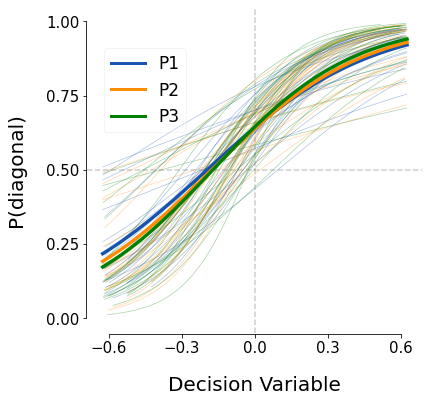

In [16]:
mycol = ["#1654B0", "darkorange", "g"]
sns.set_palette(mycol)

plt.subplots(ncols = 1, figsize = (6,6))
nrep_labels = np.unique(df.nrep) #nrep
npar_labels = np.unique(df.npar) #npar

ax = plt.axvline(0, ls='--', color= 'black', alpha=0.2)
ax = plt.axhline(0.5, ls='--', color= 'black', alpha=0.2)
for i in npar_labels: #for loop to compute the average by each participant
    df2=df.loc[df.npar == i,:]
    for cell in nrep_labels:
        sns.set_palette(mycol)
        ax = sns.regplot(x="rDV", y="deci",  data=df2.loc[df2.nrep == cell,:],
           logistic=True, y_jitter=0, scatter_kws={'alpha':0}, ci=True, n_boot=1,  label=cell,  truncate=True, 
                         line_kws ={'alpha':0.35, 'lw':0.7}); #mean all subject

for cell in nrep_labels: #for loop to compute the plot by the average sample
    sns.set_palette(mycol)
    ax = sns.regplot(x="rDV", y="deci",  data=df.loc[df.nrep == cell,:],
           logistic=True, y_jitter=0, scatter_kws={'alpha':0}, ci=True, n_boot=1,  label=cell,  truncate=True, 
                     line_kws ={'lw':3.4});
    
sns.despine(offset=1, trim=True);
plt.ylabel('P(diagonal)', fontsize = 20, labelpad=20); plt.yticks(np.arange(0, 1.1, step=0.25), fontsize = 15) 
plt.xlabel('Decision Variable', fontdict={'size':20}, labelpad=20); 
plt.yticks(np.arange(-0., 1.1, step=0.25), fontsize = 15)
plt.xticks(np.arange(-0.6, 0.61, step=0.3), fontsize = 15)
lines = [Line2D([0], [0], color=c, linewidth=3) for c in mycol]; labels = ['P1', 'P2', 'P3']; 
plt.legend(lines, labels, bbox_to_anchor=(0.32,0.9), fontsize=17, framealpha= 0.2)
#plt.savefig('deci_x_nrep.png',bbox_inches='tight')

<font size="3"> _Check whether differences are statistically significant._

Logisitc regression model with number of presentation

In [17]:
# make the model to estimate if there are statistical differences in weight or the intercept
formula = "deci ~ rDV"
log_reg_nrep = df.groupby(['npar', 'nrep']).apply(log_reg_fit, formula) 
log_reg_nrep.reset_index(inplace = True)
log_reg_nrep.tail(5)

,npar,nrep,level_2,intercept,weight,PSE
73,28,1,0,0.842237,4.544510,-0.185331
74,28,2,0,0.969789,4.697289,-0.206457
75,29,0,0,0.619073,3.501988,-0.176778
76,29,1,0,0.637875,3.736539,-0.170713
77,29,2,0,0.658416,3.667405,-0.179532


<font size="4"> _Statistical tests for Weight._

In [17]:
# Means in weight for presentation

dat = log_reg_nrep.loc[log_reg_nrep.nrep == 0,:] # without pre_deci as a factor
print('Weight mean at P1: ')
print(np.mean(dat.weight))
dat = log_reg_nrep.loc[log_reg_nrep.nrep == 1,:] # without pre_deci as a factor
print('Weight mean at P2: ')
print(np.mean(dat.weight))
dat = log_reg_nrep.loc[log_reg_nrep.nrep == 2,:] # without pre_deci as a factor
print('Weight mean at P31: ')
print(np.mean(dat.weight))

Weight mean at P1: 
3.6066215765710914
Weight mean at P2: 
3.9916435500478444
Weight mean at P31: 
4.411656947547093


In [17]:
#Checking statistical differences in Weight between the number of repetitions
pg.rm_anova(dv = 'weight', within = ['nrep'], subject = 'npar', data=log_reg_nrep, detailed = True, correction = True)

,Source,SS,DF,MS,F,p-unc,p-GG-corr,np2,eps,sphericity,W-spher,p-spher
0,nrep,7.477425,2,3.738712,13.439864,0.000021,0.00004,0.349634,0.920432,True,0.913553,0.337914
1,Error,13.909041,50,0.278181,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [19]:
#post-hoc t-test
pg.pairwise_ttests(dv='weight', within='nrep', subject='npar', padjust='bonf', 
                   tail='two-sided', effsize = 'cohen', data=log_reg_nrep) 

,Contrast,A,B,Paired,Parametric,T,dof,Tail,p-unc,p-corr,p-adjust,BF10,cohen
0,nrep,0,1,True,True,-1.671619,26.0,two-sided,0.106594,0.319782,bonf,0.694,-0.182036
1,nrep,0,2,True,True,-4.630703,26.0,two-sided,0.000089,0.000267,bonf,294.011,-0.465816
2,nrep,1,2,True,True,-3.775923,26.0,two-sided,0.000836,0.002509,bonf,39.864,-0.272053


In [20]:
#Checking statistical differences in Intercept between the number of repetitions
pg.rm_anova(dv = 'intercept', within = ['nrep'], subject = 'npar', data=log_reg_nrep, 
            detailed = True, correction = True)

,Source,SS,DF,MS,F,p-unc,p-GG-corr,np2,eps,sphericity,W-spher,p-spher
0,nrep,0.015701,2,0.007850,0.449761,0.640238,0.639228,0.017004,0.994771,True,0.994744,0.936246
1,Error,0.907647,52,0.017455,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<font size="2"> _t-test showed significant differences in weight in the third presentation compared with previous presentations._

<font size="4"> _Statistical tests for PSE._

In [21]:
#Checking statistical differences in Intercept between the number of repetitions
pg.rm_anova(dv = 'PSE', within = ['nrep'], subject = 'npar', 
            data=log_reg_nrep, detailed = True, correction = True)

,Source,SS,DF,MS,F,p-unc,p-GG-corr,np2,eps,sphericity,W-spher,p-spher
0,nrep,0.009026,2,0.004513,4.299747,0.018702,0.021581,0.141907,0.924295,True,2962.962187,1.0
1,Error,0.054580,52,0.001050,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [22]:
pg.pairwise_ttests(dv='PSE', within='nrep', subject='npar', padjust='bonf', 
                   tail='two-sided', effsize = 'cohen', data=log_reg_nrep) 

,Contrast,A,B,Paired,Parametric,T,dof,Tail,p-unc,p-corr,p-adjust,BF10,cohen
0,nrep,0,1,True,True,-1.785834,26.0,two-sided,0.085796,0.257388,bonf,0.818,-0.105258
1,nrep,0,2,True,True,-2.708191,26.0,two-sided,0.011803,0.035408,bonf,4.056,-0.153605
2,nrep,1,2,True,True,-1.136442,26.0,two-sided,0.266138,0.798415,bonf,0.365,-0.056382


<font size="2"> _t-test showed significant differences in PSE between the initial and final presentations._

# Parameters
Plotting weights and PSE

In [20]:
# Parameters

In [171]:
ax[1]

<AxesSubplot:xlabel='Repetition', ylabel='Weights'>

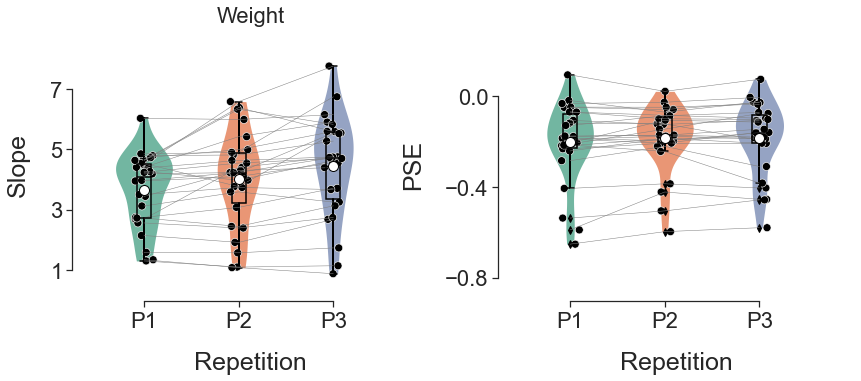

In [27]:
sns.set(style="ticks",font_scale=2)

dat = log_reg_nrep
ort = "v"; 
pal = "Set2"
dx = "nrep"; dy = "weight"; ort = "v"; pal = pal; sigma = .5
f, axes = plt.subplots(1,2,figsize=(14, 5))

# PLOTTING INTERCEPT

sns.boxplot( x = dx, y = dy, data = dat, color = "black"
      ,width = .15, zorder = 2, showcaps = True,  showmeans=True,
            meanprops={"marker":"o",
                       "markerfacecolor":"white", 
                       "markeredgecolor":"black",
                      "markersize":"10"},
      boxprops = {'facecolor':'None', "zorder":2}, showfliers=True,
      whiskerprops = {'linewidth':2, "zorder":2}, 
      saturation = 0.1, orient = ort, ax = axes[0])

sns.stripplot(x = dx, y = dy, data = dat,  color = "black", 
      edgecolor = "white",size = 8, linewidth = 0.6, jitter = 1, zorder = 2,
      orient = ort, ax = axes[0])

sns.violinplot( x = dx, y = dy, data = dat, palette = pal,split=True,
     bw = 0.5, cut = 0.0,scale = "area", width = .6, 
     inner = None, orient = ort, linewidth = 0, zorder = 0, ax = axes[0])

sns.lineplot(x = dx, y= dy, data=dat, units= "npar" , estimator=None, color = 'grey',linewidth = 0.5, ax = axes[0])


axes[0].set_xlim([-0.75, 3])
axes[0].set_xticks([0,1,2])
axes[0].set_xticklabels(['P1','P2','P3'])
axes[0].set_xlabel('Repetition', fontdict={'size':25}, labelpad=20); 


axes[0].set_ylim([0, 9])
axes[0].set_yticks(np.arange(1, 9, step=2))
axes[0].set_ylabel('Slope', fontsize = 25, labelpad=20);

axes[0].tick_params(axis='x', labelsize=22) 
axes[0].tick_params(axis='y', labelsize=22)  
axes[0].set_title('Weight',fontsize = 22)
sns.despine(offset = 1,  trim=True, ax = axes[0]);

# NOW I PLOT THE INTERCEPT
dy = "PSE"
#dy = "intercept"
sns.boxplot( x = dx, y = dy, data = dat, color = "black"
      ,width = .15, zorder = 2, showcaps = True,  showmeans=True,
            meanprops={"marker":"o",
                       "markerfacecolor":"white", 
                       "markeredgecolor":"black",
                      "markersize":"10"},
      boxprops = {'facecolor':'None', "zorder":2}, showfliers=True,
      whiskerprops = {'linewidth':2, "zorder":2}, 
      saturation = 0.1, orient = ort, ax = axes[1])

sns.stripplot(x = dx, y = dy, data = dat,  color = "black", 
      edgecolor = "white",size = 8, linewidth = 0.6, jitter = 1, zorder = 2,
      orient = ort, ax = axes[1])

sns.violinplot( x = dx, y = dy, data = dat, palette = pal,split=True,
     bw = 0.5, cut = 0.0,scale = "area", width = .6, 
     inner = None, orient = ort, linewidth = 0, zorder = 0, ax = axes[1])

#ax = sns.pointplot(x= dx, y= dy, data=dat, color = 'grey', errwidth = 0, size = 10, join = False, zorder = 8)
sns.lineplot(x = dx, y= dy, data=dat, units= "npar" , estimator=None, color = 'grey',linewidth = 0.5, ax = axes[1])


axes[1].set_xlim([-0.75, 3])
axes[1].set_xticks([0,1,2])
axes[1].set_xticklabels(['P1','P2','P3'])
axes[1].set_xlabel('Repetition', fontdict={'size':25}, labelpad=20); 

axes[1].set_ylim([-0.9, 0.3])
axes[1].set_yticks(np.arange(-0.8, 0.3, step=0.4))
axes[1].set_ylabel('PSE', fontsize = 25, labelpad=20);

axes[1].tick_params(axis='x', labelsize=22) 
axes[1].tick_params(axis='y', labelsize=22)  
#axes[1].set_title('PSE',fontsize = 22)
sns.despine(offset = 1,  trim=True, ax = axes[1]);

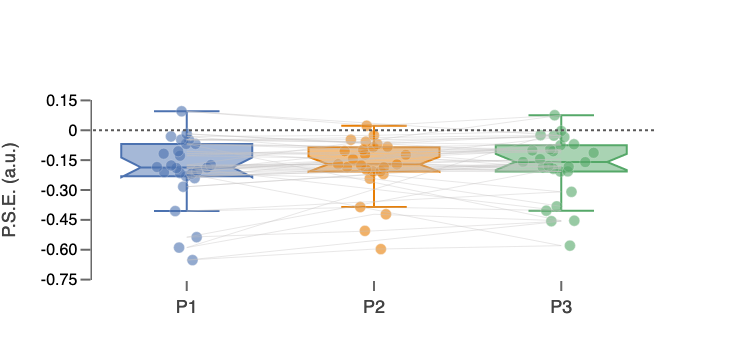

In [313]:
fig = go.Figure()

fig.update_yaxes(zeroline=False, zerolinewidth=0, zerolinecolor='Black')
fig.add_shape(type="line", xref="x", yref="y", x0=-0.5, y0=0, x1=2.5, y1=0, line=dict(
                color="#595858", width=2.2, dash="dot",))

dat = log_reg_nrep
fig.add_trace(go.Scatter( #lineplot for different category
    y=dat['PSE'], x=dat['nrep'],
    line=dict(color='#C6C2C2', width=0.4)))

dat = log_reg_nrep.loc[log_reg_nrep.nrep ==0,:]
fig.add_trace(go.Box(y=dat['PSE'], x=dat['nrep'], boxpoints='all',
    marker_color = 'rgba(0.2980392156862745, 0.4470588235294118, 0.6901960784313725, 1)',
    jitter=0.6, # add some jitter for a better separation between points
    pointpos=0,
        marker=dict(color='#2A88D4', size=11, opacity=0.6, line=dict(color='#f2f2f2', width=.4)),
    notched=True, notchwidth=0.15,))

dat = log_reg_nrep.loc[log_reg_nrep.nrep ==1,:]
fig.add_trace(go.Box(y=dat['PSE'], x=dat['nrep'], boxpoints='all',
    marker_color = 'rgba(232, 126, 4, 1)', 
    jitter=0.6, # add some jitter for a better separation between points
    pointpos=0,
        marker=dict(color='#2A88D4', size=11, opacity=0.6,
        line=dict(color='#f2f2f2', width=.4)),
    notched=True, notchwidth=0.15,))

dat = log_reg_nrep.loc[log_reg_nrep.nrep ==2,:]
fig.add_trace(go.Box(y=dat['PSE'], x=dat['nrep'], boxpoints='all',
    marker_color = 'rgba(0.3333333333333333, 0.6588235294117647, 0.40784313725490196, 1)',
    jitter=0.6, # add some jitter for a better separation between points
    pointpos=0,
        marker=dict(color='#2A88D4',size=11, opacity=0.6, line=dict(color='#f2f2f2', width=.4)),
    notched=True, notchwidth=0.15,))

fig.update_layout(boxgroupgap=0)
fig.update_layout(template='plotly_white', xaxis=dict(showgrid=False),
    yaxis=dict(gridcolor='white'))

fig.update_xaxes(showline=False, linewidth=1.5, linecolor='#696969')
fig.update_yaxes(showline=True, linewidth=1.5, linecolor='#696969',
                 tickfont=dict(family='Balto, sans-serif', color='#000000', size=16))
fig.update_xaxes(tickvals = [0, 1, 2], ticktext=['P1', 'P2', 'P3'], tickangle=0, 
                 tickfont=dict(family='Balto, sans-serif', color='#424242', size=18))
fig.update_yaxes(tickvals= [-0.75,-.60, -.45,-.30,-.15, 0, .15], 
                 ticktext=['-0.75','-0.60', '-0.45','-0.30','-0.15', '0', '0.15'])
fig.update_yaxes(ticks="outside", tickwidth=2, tickcolor='#696969', ticklen=10)
fig.update_xaxes(ticks="outside", tickwidth=2, tickcolor='#696969', ticklen=10)

fig.update_yaxes(showgrid=False)
fig.update_layout(
    yaxis_title="P.S.E. (a.u.)",
    font=dict(family="Balto, sans-serif", size=15, color= "#424242"))
fig.update_traces(showlegend=False)

fig['layout']['yaxis'].update(range=[-0.752, 0.152]);

fig.show()

<font size="5"> _Figure 3A. Logistic regression fits for each presentation separated by cardinal & diagonal._

In [530]:
dat.head(4)

,npar,subj,nblock,ntrial,nrep,cond-1,cond,rDV,DV,resp,deci-2,deci-1,deci,corr-1,r_map,correct,RT,d1,d2,d3,d4,d5,d6,o1,o2,o3,o4,o5,o6
0,1,p03,0,0,0,0,1,0.256593,0.275,m,0,0,1,0,0,1,0.735,0.557927,0.233015,-0.101612,-0.280384,0.738727,0.391887,0.959,2.055,1.218,2.859,0.888,2.595
1,1,p03,0,0,1,1,1,0.256593,0.275,z,0,1,1,1,45,1,0.776,0.557927,0.233015,-0.101612,-0.280384,0.738727,0.391887,0.959,2.055,1.218,2.859,0.888,2.595
2,1,p03,0,0,2,1,1,0.256593,0.275,m,1,1,1,1,0,1,0.738,0.557927,0.233015,-0.101612,-0.280384,0.738727,0.391887,0.959,2.055,1.218,2.859,0.888,2.595
3,1,p03,0,1,0,1,1,0.199219,0.175,m,1,1,1,1,0,1,0.615,0.527887,-0.316034,0.164260,0.718355,-0.164755,0.265600,0.600,2.873,2.028,0.896,0.328,0.497


In [ ]:
%matplotlib qt
dat = df
ort = "v"; 
pal = "Set2"
# define variables to plot
dx = "rDV"; dy = "deci"; ort = "v"; pal = pal; sigma = .5

g = sns.lmplot(x= dx, y= dy,  col="nrep", hue = 'deci-1', units = 'subj',logistic=True, y_jitter=0, scatter_kws={'alpha':0},  ci=100,
               data=dat, height=3 )

#g = sns.lmplot(x= dx, y= dy,  col="nrep", hue = 'deci-1', logistic=True, y_jitter=0, scatter_kws={'alpha':0},  ci=True, n_boot=1,
#               data=dat, height=3)
sns.despine(offset = .5,  trim=True);


In [22]:
dati = dat.loc[dat.npar == 2]  
dati

,npar,subj,nblock,ntrial,nrep,cond-1,cond,rDV,DV,resp,deci-2,deci-1,deci,corr-1,r_map,correct,RT,d1,d2,d3,d4,d5,d6,o1,o2,o3,o4,o5,o6
720,2,p18,0,0,0,1,1,0.536368,0.54,z,1,1,1,1,45,1,1.335,0.833465,0.140304,0.272202,0.356755,0.620079,0.995402,0.720,1.123,2.642,1.038,2.207,2.358
721,2,p18,0,0,1,1,1,0.536368,0.54,z,1,1,1,1,45,1,0.603,0.833465,0.140304,0.272202,0.356755,0.620079,0.995402,0.720,1.123,2.642,1.038,2.207,2.358
722,2,p18,0,0,2,1,1,0.536368,0.54,z,1,1,1,1,45,1,0.619,0.833465,0.140304,0.272202,0.356755,0.620079,0.995402,0.720,1.123,2.642,1.038,2.207,2.358
723,2,p18,0,1,0,1,0,-0.429596,-0.44,z,1,1,0,1,0,1,2.949,-0.596147,-0.549273,-0.686783,0.097532,-0.837544,-0.005364,2.983,0.177,0.123,0.431,1.507,2.751
724,2,p18,0,1,1,0,0,-0.429596,-0.44,z,1,0,0,1,0,1,1.187,-0.596147,-0.549273,-0.686783,0.097532,-0.837544,-0.005364,2.983,0.177,0.123,0.431,1.507,2.751
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1435,2,p18,5,38,1,1,1,0.314997,0.30,m,1,1,1,1,0,1,0.437,0.213633,0.998467,-0.712767,-0.327211,0.900192,0.817667,2.665,0.786,1.458,1.835,2.317,0.857
1436,2,p18,5,38,2,1,1,0.314997,0.30,z,1,1,1,1,45,1,0.540,0.213633,0.998467,-0.712767,-0.327211,0.900192,0.817667,2.665,0.786,1.458,1.835,2.317,0.857
1437,2,p18,5,39,0,1,0,-0.304992,-0.30,m,1,1,0,1,45,1,0.512,-0.895594,0.394952,0.312946,-0.840609,-0.047617,-0.754029,0.041,1.023,2.626,3.079,0.374,3.045
1438,2,p18,5,39,1,0,0,-0.304992,-0.30,m,1,0,0,1,45,1,0.456,-0.895594,0.394952,0.312946,-0.840609,-0.047617,-0.754029,0.041,1.023,2.626,3.079,0.374,3.045


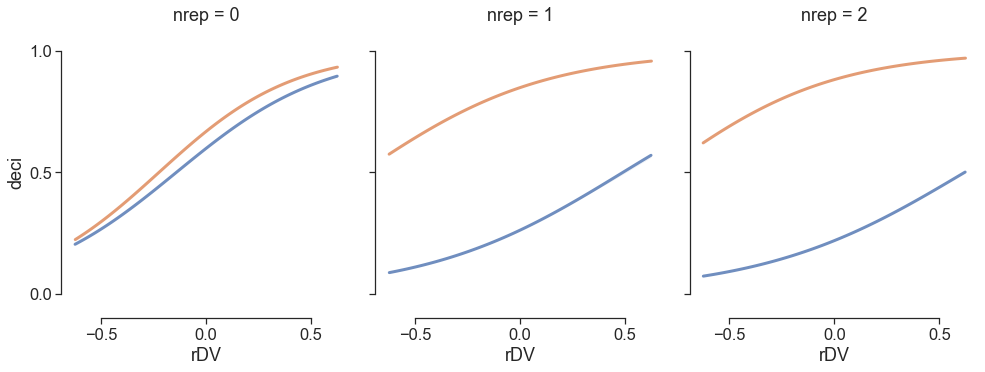

In [19]:
sns.set(font_scale = 1.5, style = 'ticks') 
dat = df
ort = "v"; 
pal = "Set2"
# define variables to plot
dx = "rDV"; dy = "deci"; ort = "v"; pal = pal; sigma = .5

g = sns.FacetGrid(data= dat,col="nrep",hue = 'deci-1', height= 5.5, aspect=.85,margin_titles=True)
g.set(ylim=[-0.1, 1.1], yticks=[-0, 0.5, 1])

#g.tight_layout()

g.map_dataframe(sns.regplot,data= df,x= dx, y= dy,logistic=True, y_jitter=0., scatter_kws={'alpha':0.0},  ci=True, n_boot=10,  
                          truncate=True, line_kws ={'alpha':0.8, 'lw':3});


#g.map_dataframe(sns.regplot,x= dx, y= dy, units = 'npar', color = "grey",
#           logistic=True, y_jitter=0,scatter_kws={'alpha':0},  ci=True, n_boot=1,  
#                          truncate=True, line_kws ={'alpha':0.8, 'lw':1});
              #  sns.lineplot, x = dx, y= dy, data=dat, units= "npar" , estimator=None, color = 'grey',linewidth = 0.5, zorder = 1)
sns.despine(offset = .5,  trim=True);

In [20]:
ax = plt.axvline(0, ls='--', color= 'black', alpha=0.2)
ax = plt.axhline(0.5, ls='--', color= 'black', alpha=0.2)

    for i in npar_labels: #for loop to compute the average by each participant
        df2=df.loc[df.npar == i,:]
        for cell in nrep_labels:
            sns.set_palette(mycol)
            ax = sns.regplot(x="rDV", y="deci",  data=df2.loc[df2.nrep == cell,:],
               logistic=True, y_jitter=0, scatter_kws={'alpha':0}, ci=True, n_boot=1,  label=cell,  truncate=True, 
                             line_kws ={'alpha':0.35, 'lw':0.7}); #mean all subject

    for cell in nrep_labels: #for loop to compute the plot by the average sample
        sns.set_palette(mycol)
        ax = sns.regplot(x="rDV", y="deci",  data=df.loc[df.nrep == cell,:],
               logistic=True, y_jitter=0, scatter_kws={'alpha':0}, ci=True, n_boot=1,  label=cell,  truncate=True, 
                         line_kws ={'lw':3.4});
    
sns.despine(offset=1, trim=True);
plt.ylabel('P(diagonal)', fontsize = 20, labelpad=20); plt.yticks(np.arange(0, 1.1, step=0.25), fontsize = 15) 
plt.xlabel('Decision Variable', fontdict={'size':20}, labelpad=20); 
plt.yticks(np.arange(-0., 1.1, step=0.25), fontsize = 15)
plt.xticks(np.arange(-0.6, 0.6, step=0.3), fontsize = 15)
lines = [Line2D([0], [0], color=c, linewidth=3) for c in mycol]; labels = ['P1', 'P2', 'P3']; 
plt.legend(lines, labels, bbox_to_anchor=(0.32,0.9), fontsize=17, framealpha= 0.2)
#plt.savefig('deci_x_nrep.png',bbox_inches='tight')

IndentationError: unexpected indent (806590938.py, line 4)

In [110]:
pre_deci_labels

array([0, 1])

In [111]:
 dat

,npar,subj,nblock,ntrial,nrep,cond-1,cond,rDV,DV,resp,deci-2,deci-1,deci,corr-1,r_map,correct,RT,d1,d2,d3,d4,d5,d6,o1,o2,o3,o4,o5,o6
17830,29,p09,0,0,2,1,1,0.206945,0.2,z,1,1,1,1,45,1,0.908,-0.528383,0.616496,0.417352,-0.446895,0.589003,0.594096,1.756,0.936,2.585,1.788,0.624,0.626
17833,29,p09,0,1,2,0,0,-0.122070,-0.1,z,1,1,1,0,45,0,0.847,-0.873195,-0.231482,-0.888992,0.117386,0.710197,0.433668,1.521,1.269,3.098,1.132,2.470,0.563
17836,29,p09,0,2,2,0,0,-0.211692,-0.2,z,0,1,1,0,45,0,0.640,-0.882862,-0.686264,0.238107,-0.373047,0.703595,-0.269679,0.046,1.694,2.057,1.817,0.669,1.284
17848,29,p09,0,6,2,0,0,-0.193623,-0.2,m,0,1,0,0,45,1,1.070,-0.088879,-0.187155,-0.041015,-0.051201,-0.722952,-0.070535,1.213,1.890,2.765,2.769,1.462,0.365
17853,29,p09,0,8,2,0,0,-0.320184,-0.3,m,1,1,1,0,0,0,0.866,-0.295663,-0.017059,-0.641465,-0.653679,-0.348620,0.035380,2.865,0.386,1.430,0.136,1.315,2.735
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18519,29,p09,5,32,2,1,1,0.382306,0.4,z,1,1,1,1,45,1,0.675,0.972484,0.795786,0.085319,0.084281,-0.468823,0.824788,2.367,2.276,1.997,1.145,2.933,2.425
18528,29,p09,5,35,2,1,1,0.220432,0.2,z,1,1,1,1,45,1,0.889,-0.603787,0.774377,0.222310,0.919008,0.902220,-0.891539,2.986,0.874,0.480,2.388,0.747,3.099
18531,29,p09,5,36,2,0,0,-0.202873,-0.2,m,1,1,1,0,0,0,0.406,-0.210591,-0.508530,-0.174422,-0.316034,-0.845183,0.837521,0.310,0.193,1.895,2.873,1.510,2.420
18537,29,p09,5,38,2,0,0,-0.407779,-0.4,m,1,1,1,0,0,0,0.463,-0.977082,-0.048135,-0.739740,-0.939922,0.382738,-0.124530,0.009,1.197,1.673,3.118,0.543,1.227


## Effect of previous decision in the current trial decision

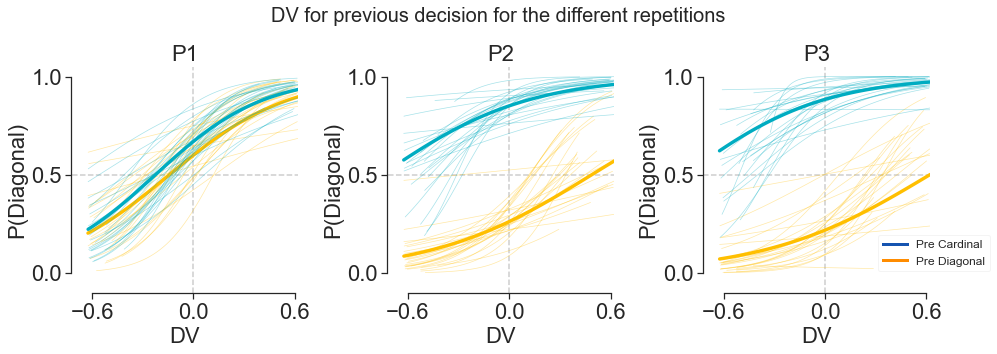

In [21]:
sns.set(font_scale = 1, style = 'ticks') 
mycol = ['#ffbf00' , '#00acc1'] #cardinal #diagonal
sns.set_palette(mycol)

titles = ['P1', 'P2', 'P3']
pre_deci_labels = np.unique(df['deci-1'])     #pre_deci
nreps = np.unique(df['nrep'])     #nreps


fig, axes = plt.subplots(1, 3, figsize=(14, 5))
fig.suptitle("DV for previous decision for the different repetitions", fontsize=20)

for j in nreps:
    axes[j].axvline(0, ls='--', color= 'black', alpha = 0.2)
    axes[j].axhline(0.5, ls='--', color= 'black', alpha = 0.2)
    for cell in pre_deci_labels:
        for i in npar_labels: #this for loop makes the plot for each participant 
            dat = df.loc[(df.npar == i) & (df['deci-1'] == cell) & (df.nrep == j),:]
            sns.regplot(x="rDV", y="deci",  data= dat,
               logistic=True, y_jitter=0, scatter_kws={'alpha':0}, ci=True, n_boot=1,  
                              label=cell,  truncate=True, line_kws ={'alpha':0.35, 'lw':0.7}, ax = axes[j], color = mycol[cell]);
        
        sns.regplot(x="rDV", y="deci",  data=df.loc[(df['deci-1'] == cell) & (df.nrep == j),:],
               logistic=True, y_jitter=.0, scatter_kws={'alpha':0}, ci=True, n_boot=1,  
                          label=cell, truncate=True, line_kws={'lw':3.4}, ax = axes[j], color = mycol[cell]);
        
    # Tweaking subplots
    axes[j].set_title(titles[j],fontsize = 22)
   
    axes[j].set_xlabel('DV', fontsize = 22)
    axes[j].set_ylabel('P(Diagonal)', fontsize = 22)
    
    axes[j].set_xlim(-0.72,0.62)
    axes[j].set_xticks([-0.6,0,0.6]) 
    
    axes[j].tick_params(axis='x', labelsize=22)   
    axes[j].set_yticks([0.0,0.5,1]) 
    axes[j].set_ylim(-0.1,1.05)
    axes[j].tick_params(axis='y', labelsize=22) 
    #axes[j].xticks(np.arange(-0.6, 0.61, step=0.3), fontsize = 25); 
    sns.despine(ax= axes[j], offset=0.5, trim = True);
    
labels = ['Pre Cardinal', 'Pre Diagonal']; 
plt.legend(lines, labels, bbox_to_anchor=(0.745,0.175), fontsize=12, framealpha= 0.2)
        
#plt.setp(ax.get_xticklabels(), fontsize=12, fontweight="bold", 
#         horizontalalignment="left")       
        #fig[j].title('P1', fontsize= 35); 
    
#subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=None)
fig.tight_layout()
#axes[0].ylabel('p(diagonal)', fontsize = 20, labelpad=20); axes[0].yticks(np.arange(0, 1.1, step=0.25), fontsize = 25); plt.xlabel(' ', fontsize = 0)


<font size="3"> _Check whether differences are statistically significant._

Logisitc regression model with previous decision by each presentation

In [45]:
formula = "deci ~ rDV"
log_reg_preDeci = df.groupby(['npar', 'nrep', 'deci-1']).apply(log_reg_fit, formula)
log_reg_preDeci.reset_index(inplace = True)
log_reg_preDeci.head(6)

,npar,nrep,deci-1,level_3,intercept,weight,PSE
0,1,0,0,0,0.871362,5.161564,-0.168817
1,1,0,1,0,0.968031,4.405930,-0.219711
2,1,1,0,0,-2.325401,6.937026,0.335216
3,1,1,1,0,2.024836,5.966449,-0.339370
4,1,2,0,0,-1.969241,3.317937,0.593514
5,1,2,1,0,2.872230,1.114550,-2.577032


In [46]:
dat = log_reg_preDeci.loc[log_reg_preDeci.nrep == 0,:] # with pre_deci as a factor
print(np.mean(dat.weight))
print()

dat = log_reg_preDeci.loc[log_reg_preDeci.nrep == 1,:] # with pre_deci as a factor
print(np.mean(dat.weight))
print()

dat = log_reg_preDeci.loc[log_reg_preDeci.nrep == 2,:] # with pre_deci as a factor
print(np.mean(dat.weight))

3.7396622316939445

3.080671360138533

3.426923842216219


In [28]:
#Checking statistical differences in Weight between the number of repetitions & previous decision
pg.rm_anova(dv = 'weight', within = ['nrep', 'pre_deci'], subject = 'npar', 
            data=log_reg_preDeci, detailed = True, correction = True)

,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,np2,eps
0,nrep,17.966197,2,52,8.983099,6.503004,0.003015,0.006809,0.200074,0.763511
1,pre_deci,2.459921,1,26,2.459921,0.337826,0.566092,0.566092,0.012827,1.000000
2,nrep * pre_deci,6.446002,2,52,3.223001,0.649701,0.526388,0.466070,0.024379,0.656333


In [29]:
# post-hoc t-test for changes in weight by previous decisions and number of repetition
pg.pairwise_ttests(dv='weight', within= ['nrep', 'pre_deci'], subject='npar', padjust='bonf',
                   tail='two-sided', interaction=True, effsize = 'cohen', data=log_reg_preDeci) 

,Contrast,nrep,A,B,Paired,Parametric,T,dof,Tail,p-unc,p-corr,p-adjust,BF10,cohen
0,nrep,-,0,1,True,True,3.804053,26.0,two-sided,0.000778,0.002333,bonf,42.505,0.565897
1,nrep,-,0,2,True,True,2.666178,26.0,two-sided,0.013017,0.039051,bonf,3.736,0.305095
2,nrep,-,1,2,True,True,-1.267557,26.0,two-sided,0.216191,0.648574,bonf,0.419,-0.228770
3,pre_deci,-,0,1,True,True,-0.581228,26.0,two-sided,0.566092,NaN,NaN,0.238,-0.142376
4,nrep * pre_deci,0,0,1,True,True,-0.951462,26.0,two-sided,0.350132,1.000000,bonf,0.307,-0.166633
5,nrep * pre_deci,1,0,1,True,True,0.611889,26.0,two-sided,0.545925,1.000000,bonf,0.242,0.136732
6,nrep * pre_deci,2,0,1,True,True,-0.715940,26.0,two-sided,0.480409,1.000000,bonf,0.258,-0.235252


<font size="2"> _t-test showed significantly that previous choices reduced discriminability from P1 to P2 and from P1 to P3._

<font size="4"> Statistical tests for PSE

In [30]:
df.reset_index(drop=True, inplace=True) # function resets the row indexes of the pandas dataframe
pg.rm_anova(dv = 'PSE', within = ['nrep', 'pre_deci'], subject = 'npar', 
            data=log_reg_preDeci, detailed = True, correction = True)

,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,np2,eps
0,nrep,1.423181,2,52,0.711590,0.802917,0.453496,0.453466,0.029956,0.999717
1,pre_deci,35.723772,1,26,35.723772,21.888779,0.000079,0.000079,0.457075,1.000000
2,nrep * pre_deci,19.139836,2,52,9.569918,9.349854,0.000340,0.000372,0.264495,0.982958


In [31]:
pg.pairwise_ttests(dv='PSE', within= ['pre_deci', 'nrep'], subject='npar', padjust='bonf', 
                   tail='two-sided', interaction=True, effsize = 'cohen', data=log_reg_preDeci) 

,Contrast,pre_deci,A,B,Paired,Parametric,T,dof,Tail,p-unc,p-corr,p-adjust,BF10,cohen
0,pre_deci,-,0,1,True,True,4.678544,26.0,two-sided,0.000079,NaN,NaN,329.486,1.235830
1,nrep,-,0,1,True,True,-0.282102,26.0,two-sided,0.780099,1.000000,bonf,0.211,-0.075189
2,nrep,-,0,2,True,True,0.931011,26.0,two-sided,0.360413,1.000000,bonf,0.302,0.246956
3,nrep,-,1,2,True,True,1.201172,26.0,two-sided,0.240513,0.721539,bonf,0.39,0.233577
4,pre_deci * nrep,0,0,1,True,True,-4.937436,26.0,two-sided,0.000040,0.000238,bonf,611.452,-1.547917
5,pre_deci * nrep,0,0,2,True,True,-4.193148,26.0,two-sided,0.000282,0.001692,bonf,104.576,-1.327330
6,pre_deci * nrep,0,1,2,True,True,0.152242,26.0,two-sided,0.880172,1.000000,bonf,0.206,0.020806
7,pre_deci * nrep,1,0,1,True,True,1.640282,26.0,two-sided,0.112991,0.677947,bonf,0.665,0.440853
8,pre_deci * nrep,1,0,2,True,True,2.819131,26.0,two-sided,0.009087,0.054524,bonf,5.055,0.747797
9,pre_deci * nrep,1,1,2,True,True,1.126972,26.0,two-sided,0.270048,1.000000,bonf,0.361,0.236383


In [32]:
dat =log_reg_preDeci.loc[log_reg_preDeci.nrep == 0]
pg.pairwise_ttests(dv='PSE', within= ['pre_deci'], subject='npar', 
                   padjust='bonf', tail='two-sided', interaction=True, effsize = 'cohen', data=dat) 

,Contrast,A,B,Paired,Parametric,T,dof,Tail,p-unc,BF10,cohen
0,pre_deci,0,1,True,True,-0.071054,26.0,two-sided,0.943898,0.204,-0.013457


In [33]:
dat = log_reg_preDeci.loc[log_reg_preDeci['deci-1'] == 1]
pg.ttest(dat['PSE'], 0)

,T,dof,tail,p-val,CI95%,cohen-d,BF10,power
T-test,-4.242337,80,two-sided,0.000059,"[-1.05, -0.38]",0.471371,322.25,0.987157


In [34]:
# post-hoc t-test for changes in weight by previous decisions and number of repetition
# INTERACTIONS
dat = log_reg_preDeci.loc[log_reg_preDeci['deci-1'] == 0] #cardinal
pg.pairwise_ttests(dv='PSE', within= ['nrep'], subject='npar', padjust='bonf', 
                   tail='two-sided', interaction=False, effsize = 'cohen', data=dat) 

,Contrast,A,B,Paired,Parametric,T,dof,Tail,p-unc,p-corr,p-adjust,BF10,cohen
0,nrep,0,1,True,True,-4.937436,26.0,two-sided,0.000040,0.000119,bonf,611.452,-1.547917
1,nrep,0,2,True,True,-4.193148,26.0,two-sided,0.000282,0.000846,bonf,104.576,-1.327330
2,nrep,1,2,True,True,0.152242,26.0,two-sided,0.880172,1.000000,bonf,0.206,0.020806


In [35]:
# post-hoc t-test for changes in weight by previous decisions and number of repetition
# INTERACTIONS
dat = log_reg_preDeci.loc[log_reg_preDeci['deci-1'] == 1] #diagonal
pg.pairwise_ttests(dv='PSE', within= ['nrep'], subject='npar', padjust='bonf', 
                   tail='two-sided', interaction=False, effsize = 'cohen', data=dat) 

,Contrast,A,B,Paired,Parametric,T,dof,Tail,p-unc,p-corr,p-adjust,BF10,cohen
0,nrep,0,1,True,True,1.640282,26.0,two-sided,0.112991,0.338973,bonf,0.665,0.440853
1,nrep,0,2,True,True,2.819131,26.0,two-sided,0.009087,0.027262,bonf,5.055,0.747797
2,nrep,1,2,True,True,1.126972,26.0,two-sided,0.270048,0.810145,bonf,0.361,0.236383


<font size="2"> post-hoc t-test showed:
    
    
<font size="2"> 1. _PSE in Cardinal condition: PSE displacement in P2 and P3 was significant compared with the PSE in P1._ 
    
<font size="2"> 2. _PSE in Diagonal condition: PSE displacement in P3 was significant compared with the PSE in P1._

<font size="5"> _Figure 3B. Beta weight by presentation and condition._

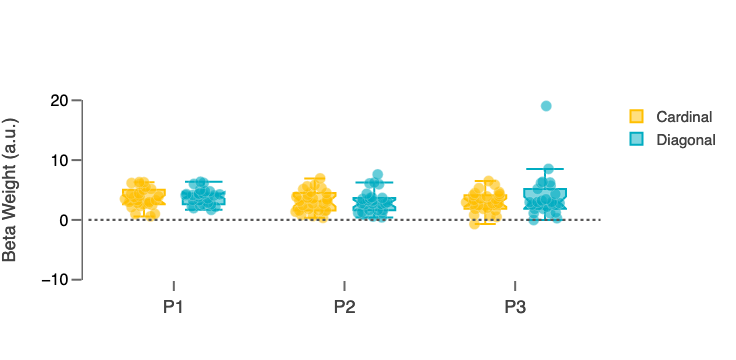

In [47]:
fig = go.Figure()

dat = log_reg_preDeci.loc[(log_reg_preDeci['deci-1'] == 0),:]
fig.add_trace(go.Box(y=dat['weight'], x=dat['nrep'], boxpoints='all',
    jitter=0.99, 
    pointpos=0,
        marker=dict(color='#2A88D4', size=11, opacity=0.6, line=dict(color='#f2f2f2', width=.4)),
    notched=True, notchwidth=0.15,
    name='Cardinal', marker_color=  "#ffbf00"))

dat = log_reg_preDeci.loc[(log_reg_preDeci['deci-1'] == 1),:]
fig.add_trace(go.Box(y=dat['weight'], x=dat['nrep'], boxpoints='all', pointpos=0, jitter=0.99,
    whiskerwidth=0.9,
    marker=dict(color='#FA920A',size=11,opacity=0.6,line=dict(color='#f2f2f2', width=.4)),
    notched=True, notchwidth=0.15, 
    name='Diagonal', marker_color= '#00acc1'))

fig.update_yaxes(zeroline=False, zerolinewidth=0, zerolinecolor='Black')
fig.add_shape(type="line", xref="x", yref="y", x0=-0.5, y0=0, x1=2.5, y1=0, line=dict(
                color="#595858", width=2.2, dash="dot",))

fig.update_layout(boxmode='group',)
fig.update_layout(template='plotly_white', xaxis=dict(showgrid=False),
    yaxis=dict(gridcolor='white'))

fig.update_xaxes(showline=False, linewidth=1.5, linecolor='#696969')
fig.update_yaxes(showline=True, linewidth=1.5, linecolor='#696969',
                 tickfont=dict(family='Balto, sans-serif', color='#000000', size=16))

fig.update_xaxes(tickvals = [0, 1, 2], ticktext=['P1', 'P2', 'P3'], tickangle=0, 
                 tickfont=dict(family='Balto, sans-serif', color='#424242', size=18))
fig.update_yaxes(ticks="outside", tickwidth=2, tickcolor='#696969', ticklen=10)
fig.update_xaxes(ticks="outside", tickwidth=2, tickcolor='#696969', ticklen=10)


fig.update_yaxes(showgrid=False)
fig.update_layout(
    yaxis_title="Beta Weight (a.u.)",
    font=dict(
        family="Balto, sans-serif",
        size=15,
        color= "#424242"   ))


fig['layout']['yaxis'].update(range=[-10.05, 20.05]);

fig.show()

<font size="5"> _Figure 3C. PSE by presentation and condition._

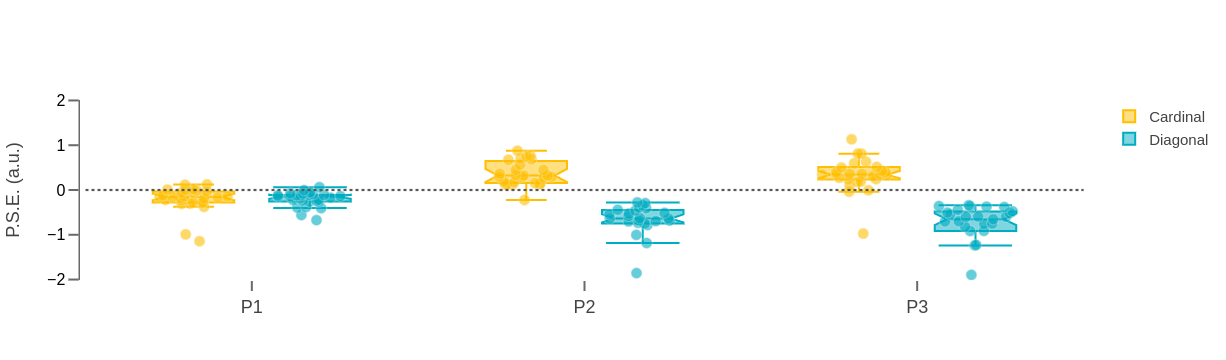

In [37]:
fig = go.Figure()

dat = log_reg_preDeci.loc[(log_reg_preDeci['deci-1'] == 0),:]
fig.add_trace(go.Box(y=dat['PSE'], x=dat['nrep'], boxpoints='all',
    jitter=0.99, pointpos=0,
        marker=dict(color='#2A88D4', size=11, opacity=0.6, line=dict(color='#f2f2f2', width=.4)),
    notched=True, notchwidth=0.15,
    name='Cardinal', marker_color="#ffbf00"))

dat = log_reg_preDeci.loc[(log_reg_preDeci['deci-1'] == 1),:]
fig.add_trace(go.Box(y=dat['PSE'],x=dat['nrep'],
    boxpoints='all', pointpos=0, jitter=0.99,
    whiskerwidth=0.9,
    marker=dict(color='#FA920A',size=11,opacity=0.6,line=dict(color='#f2f2f2', width=.4)),
    notched=True, notchwidth=0.15, 
    name='Diagonal',marker_color='#00acc1'))

fig.update_yaxes(zeroline=False, zerolinewidth=0, zerolinecolor='Black')
fig.add_shape(type="line", xref="x", yref="y", x0=-0.5, y0=0, x1=2.5, y1=0, line=dict(
                color="#595858", width=2.2, dash="dot",))
fig.update_layout(boxmode='group',)
fig.update_layout(template='plotly_white', xaxis=dict(showgrid=False),
    yaxis=dict(gridcolor='white'))

fig.update_xaxes(showline=False, linewidth=1.5, linecolor='#696969')
fig.update_yaxes(showline=True, linewidth=1.5, linecolor='#696969',
                 tickfont=dict(family='Balto, sans-serif', color='#000000', size=16))

fig.update_xaxes(tickvals = [0, 1, 2], ticktext=['P1', 'P2', 'P3'], 
                 tickangle=0, tickfont=dict(family='Balto, sans-serif', color='#424242', size=18))
fig.update_yaxes(ticks="outside", tickwidth=2, tickcolor='#696969', ticklen=10)
fig.update_xaxes(ticks="outside", tickwidth=2, tickcolor='#696969', ticklen=10)


fig.update_yaxes(showgrid=False)
fig.update_layout(
    yaxis_title="P.S.E. (a.u.)",
    font=dict(family="Balto, sans-serif", size=15, color= "#424242"))

fig['layout']['yaxis'].update(range=[-2.01, 2.01]);

fig.show()

<font size="5"> _Figure 4A. Beta Weight by presentation and sample._

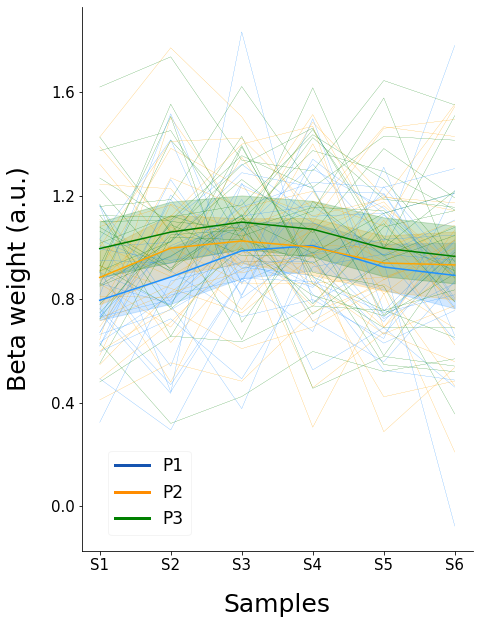

In [49]:
plt.subplots(ncols = 1, figsize = (7,10))
nrep_labels = np.unique(df.nrep) #nrep
n_par_labels = np.unique(df.npar)

mycol = ["#1654B0", "darkorange", "g"]

for i in n_par_labels:
    dat= log_regstim_params.loc[log_regstim_params.npar ==i,:]
    sns.lineplot(x="stim", y="weight", hue="nrep", 
                 palette= ["dodgerblue", "orange", "green"], err_style=None,ci=95, lw=0.2, data=dat)
    plt.xlabel('Stimulus', fontsize= 13)
    plt.ylabel('Weight', fontsize= 13)
    legend =plt.legend(frameon=False, title = 'Rep')
    legend.remove()    
sns.lineplot(x="stim", y="weight", hue="nrep",
             palette= ["dodgerblue", "orange", "green"], data=log_regstim_params)

ind = ind = np.arange(6)
plt.ylabel('Beta weight (a.u.)', fontsize = 25, labelpad=20); 
plt.yticks(np.arange(0, 1.801, step=0.4), fontsize = 15) #labelpad is the space between the label and the axis
plt.xlabel('Samples', fontdict={'size':25}, labelpad=20); 
plt.xticks(ind, ('S1', 'S2', 'S3', 'S4', 'S5', 'S6'), fontsize = 15)

lines = [Line2D([0], [0], color=c, linewidth=3) for c in mycol]; 
labels = ['P1', 'P2', 'P3']; 
lines = [Line2D([0], [0], color=c, linewidth=3) for c in mycol]; labels = ['P1', 'P2', 'P3']; 
plt.legend(lines, labels, bbox_to_anchor=(0.3,0.2), fontsize=17, framealpha= 0.2)

sns.despine(top=True);
plt.savefig('sample_weight4part.png',bbox_inches='tight')

<font size="4"> Statistical tests for Weight

In [38]:
# ANOVA to check if weight depends on the position of the stimuli sample: recency and primacy bias

pg.rm_anova(dv = 'weight', within = ['nrep', 'stim'], subject = 'npar', 
            data=log_regstim_params, detailed = True, correction = True)

/home/freeman/anaconda3/lib/python3.8/site-packages/pingouin/distribution.py:459: UserWarning:

Epsilon values might be innaccurate in two-way repeated measures design where each  factor has more than 2 levels. Please  double-check your results.



,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,np2,eps
0,nrep,1.052703,2,50,0.526352,10.891371,0.000119,0.000281,0.303454,0.864022
1,stim,1.224314,5,125,0.244863,1.893686,0.100038,0.113745,0.070414,0.839404
2,nrep * stim,0.259867,10,250,0.025987,1.419852,0.171671,0.232021,0.053742,0.407799


In [42]:
log_regstim_params

,npar,nrep,stim,level_3,intercept,weight,PSE
0,1,0,d1,0,-0.913563,-1.029562,-0.887331
1,1,0,d2,0,-0.883891,-0.910509,-0.970765
2,1,0,d3,0,-0.871265,-0.733091,-1.188482
3,1,0,d4,0,-0.863337,-0.799175,-1.080286
4,1,0,d5,0,-0.816901,-0.648715,-1.259261
...,...,...,...,...,...,...,...
463,29,2,d2,0,-0.342614,-0.320535,-1.068882
464,29,2,d3,0,-0.358326,-0.424277,-0.844557
465,29,2,d4,0,-0.374224,-0.598483,-0.625288
466,29,2,d5,0,-0.334473,-0.521094,-0.641866


In [62]:
formula = "deci ~ dv"
log_regstim_params = dflong.groupby(['npar','nrep', 'stim']).apply(log_reg_fit, formula)
log_regstim_params.reset_index(inplace = True)


In [40]:
# post-hoc t-test
pg.pairwise_ttests(dv='weight', within=['nrep', 'stim'], subject='npar', padjust='bonf', 
                   effsize = 'cohen', interaction=False, data=log_regstim_params) 

,Contrast,A,B,Paired,Parametric,T,dof,Tail,p-unc,p-corr,p-adjust,BF10,cohen
0,nrep,0,1,True,True,-1.447206,26.0,two-sided,0.159790,0.479369,bonf,0.517,-0.216513
1,nrep,0,2,True,True,-4.458136,26.0,two-sided,0.000140,0.000421,bonf,195.188,-0.653990
2,nrep,1,2,True,True,-4.107599,26.0,two-sided,0.000353,0.001059,bonf,85.636,-0.361566
3,stim,d1,d2,True,True,-1.582897,26.0,two-sided,0.125535,1.000000,bonf,0.615,-0.363347
4,stim,d1,d3,True,True,-3.126167,26.0,two-sided,0.004323,0.064852,bonf,9.524,-0.767649
5,stim,d1,d4,True,True,-2.322685,26.0,two-sided,0.028289,0.424334,bonf,1.968,-0.547645
6,stim,d1,d5,True,True,-0.881893,26.0,two-sided,0.385915,1.000000,bonf,0.29,-0.199763
7,stim,d1,d6,True,True,-0.378904,26.0,two-sided,0.707836,1.000000,bonf,0.218,-0.075226
8,stim,d2,d3,True,True,-1.317111,26.0,two-sided,0.199292,1.000000,bonf,0.442,-0.339072
9,stim,d2,d4,True,True,-0.831418,26.0,two-sided,0.413308,1.000000,bonf,0.279,-0.165943


<font size="2"> _t-test showed that discriminabilty was larger in the third sample than in the first one._

<font size="5"> _Figure 4B. Intercept by presentation and sample._

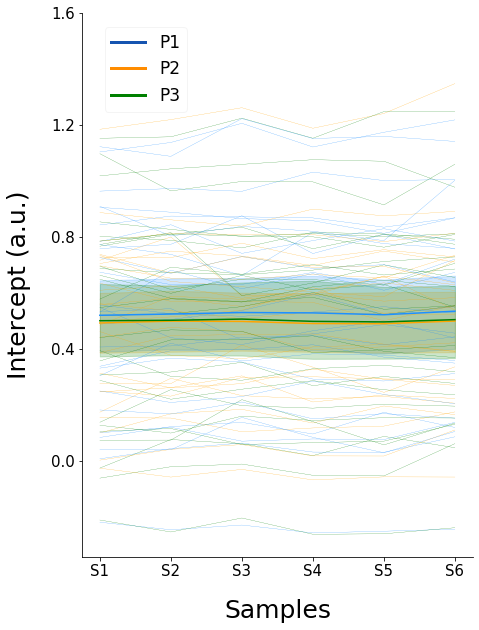

In [41]:
plt.subplots(ncols = 1, figsize = (7,10))
nrep_labels = np.unique(df.nrep) #nrep
n_par_labels = np.unique(df.npar)#npar

mycol = ["#1654B0", "darkorange", "g"]

for i in n_par_labels:
    dat= log_regstim_params.loc[log_regstim_params.npar ==i,:]
    sns.lineplot(x="stim", y="intercept", hue="nrep", 
                 palette= ["dodgerblue", "orange", "green"], err_style=None,ci=95, lw=0.2, data=dat)
    plt.xlabel('Stimulus', fontsize= 13)
    plt.ylabel('Intercept', fontsize= 13)
    legend =plt.legend(frameon=False, title = 'Rep')
    legend.remove()    
sns.lineplot(x="stim", y="intercept", hue="nrep",
             palette= ["dodgerblue", "orange", "green"], data=log_regstim_params)

legend.remove()
ind = ind = np.arange(6)
plt.ylabel('Intercept (a.u.)', fontsize = 25, labelpad=20); 
plt.yticks(np.arange(0, 1.801, step=0.4), fontsize = 15) 
plt.xlabel('Samples', fontdict={'size':25}, labelpad=20); 
plt.xticks(ind, ('S1', 'S2', 'S3', 'S4', 'S5', 'S6'), fontsize = 15)

lines = [Line2D([0], [0], color=c, linewidth=3) for c in mycol]; 
labels = ['P1', 'P2', 'P3']; 
lines = [Line2D([0], [0], color=c, linewidth=3) for c in mycol]; labels = ['P1', 'P2', 'P3']; 
plt.legend(lines, labels, bbox_to_anchor=(0.29,0.99), fontsize=17, framealpha= 0.2)

sns.despine(top=True);
plt.savefig('sample_intercept4part.png',bbox_inches='tight')

<font size="4"> Statistical tests for Inercept

In [63]:
# ANOVA to check if there are differences at the INTERCEPT depending on the stimuli position

pg.rm_anova(dv = 'intercept', within = ['nrep', 'stim'], subject = 'npar', 
            data=log_regstim_params, detailed = True, correction = True)

/home/freeman/anaconda3/lib/python3.8/site-packages/pingouin/distribution.py:459: UserWarning:

Epsilon values might be innaccurate in two-way repeated measures design where each  factor has more than 2 levels. Please  double-check your results.



,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,np2,eps
0,nrep,0.060078,2,50,0.030039,0.499465,0.609851,0.606512,0.019587,0.981766
1,stim,0.012628,5,125,0.002526,0.608137,0.693803,0.668350,0.023748,0.854648
2,nrep * stim,0.001859,10,250,0.000186,0.796340,0.632372,0.430930,0.030870,0.157632


<font size="2"> _There were non statisitcal differences in sample position and intercept._

<font size="5"> _Figure 5 A & B. Category similarity between consecutive samples._

Logisitc regression model with the category of the previous stimuli sample

In [76]:
# First, build a logistic model with presentations and the category of previous sample

formula = "deci ~ dv"

log_regpre_deci_params = dflong_seq.groupby(['npar', 'nrep', 'cong_stim_DV']).apply(log_reg_fit, formula)
log_regpre_deci_params.reset_index(inplace = True)
log_regpre_deci_params.head()

,npar,nrep,cong_stim_DV,level_3,intercept,weight,PSE
0,1,0,0,0,0.976791,1.679745,-0.581511
1,1,0,1,0,0.801696,0.159947,-5.012268
2,1,1,0,0,0.710433,2.020396,-0.351630
3,1,1,1,0,0.474156,0.252456,-1.878173
4,1,2,0,0,0.689184,1.940019,-0.355246


<font size="5"> _5A. Beta Weight._

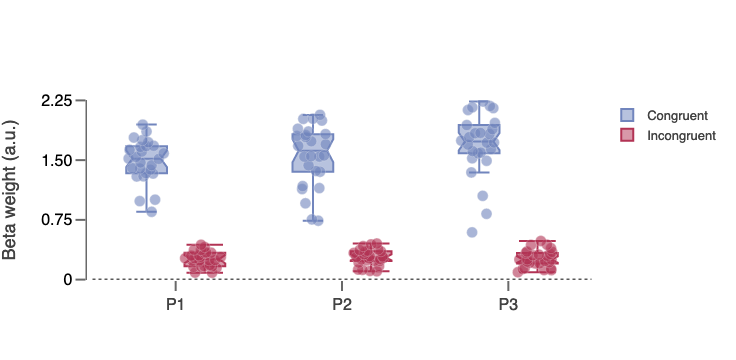

In [77]:
fig = go.Figure()
data = log_regpre_deci_params

dat = log_regpre_deci_params.loc[(log_regpre_deci_params.cong_stim_DV == 0),:]
fig.add_trace(go.Box(y=dat['weight'], x=dat['nrep'], boxpoints='all', jitter=0.99, 
    pointpos=0,
        marker=dict(color='#2A88D4', size=11, opacity=0.6, line=dict(color='#f2f2f2', width=.4)),
    notched=True, notchwidth=0.15,
    name='Congruent', # Stimuli follwed by one of the same category (D-D or C-C)
    marker_color='#7185bd'))

dat = log_regpre_deci_params.loc[(log_regpre_deci_params.cong_stim_DV == 1),:]
fig.add_trace(go.Box(y=dat['weight'], x=dat['nrep'], boxpoints='all', pointpos=0, jitter=0.99,
    whiskerwidth=0.9,
    marker=dict(color='#FA920A', size=11, opacity=0.6, line=dict(color='#f2f2f2', width=.4)),
    notched=True, notchwidth=0.15, 
    name='Incongruent', # Stimuli follwed by one of the different category (D-C or C-D)
    marker_color='#b23354'))

fig.update_layout(boxmode='group',)
fig.update_layout(template='plotly_white', xaxis=dict(showgrid=False),
    yaxis=dict(gridcolor='white'))

fig.update_xaxes(showline=False, linewidth=1.5, linecolor='#696969')
fig.update_yaxes(showline=True, linewidth=1.5, linecolor='#696969',
                 tickfont=dict(family='Balto, sans-serif', color='#000000', size=16))
fig.update_xaxes(tickvals = [0, 1, 2], ticktext=['P1', 'P2', 'P3'], 
                 tickangle=0, tickfont=dict(family='Balto, sans-serif', color='#424242', size=16))
fig.update_yaxes(tickvals= [0, .75, 1.50, 2.25], ticktext=['0', '0.75', '1.50', '2.25', '1', '1.25'])
fig.update_yaxes(ticks="outside", tickwidth=2, tickcolor='#696969', ticklen=10)
fig.update_xaxes(ticks="outside", tickwidth=2, tickcolor='#696969', ticklen=10)

fig.update_yaxes(showgrid=False)
fig.update_layout(
    yaxis_title="Beta weight (a.u.)",
    font=dict(
        family="Balto, sans-serif",size=15, color= "#424242" ))

fig.update_layout(
    legend=dict(traceorder="normal", font=dict(family="Balto, sans-serif",size=13,color="#424242")))

fig['layout']['yaxis'].update(range=[-.005, 2.255])

fig.update_yaxes(zeroline=False, zerolinewidth=0, zerolinecolor='Black')
fig.add_shape(type="line", xref="x", yref="y", x0=-0.5, y0=0, x1=2.5, y1=0, line=dict(
                color="#595858", width=2.2, dash="dot",))

fig.show()

<font size="4"> Statistical tests for Beta Weight

In [79]:
#Checking statistical differences in Weight between the number of repetitions & the previous sample category
# If there are differences after adreesing the ANOVA, the differences that we saw at the plot are significant

pg.rm_anova(dv = 'weight', within = ['cong_stim_DV','nrep'], subject = 'npar', 
            data=log_regpre_deci_params, detailed = True, correction = True)

#Weight was larger in those samples that followed a sample from the same category

,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,np2,eps
0,cong_stim_DV,67.337315,1,25,67.337315,407.414525,5.445966e-17,5.445966e-17,0.942185,1.000000
1,nrep,0.302400,2,50,0.151200,9.148145,4.114551e-04,4.874905e-04,0.267896,0.967416
2,cong_stim_DV * nrep,0.294277,2,50,0.147138,12.946066,2.946668e-05,3.934609e-05,0.341170,0.962088


Post-hoc t-test

In [80]:
#post-hoc t-test
pg.pairwise_ttests(dv='weight', within=['cong_stim_DV','nrep'], subject='npar', 
                   padjust='bonf', effsize = 'cohen',interaction=False, data=log_regpre_deci_params) 

,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,cohen
0,cong_stim_DV,0,1,True,True,20.184512,25.0,two-sided,5.445966e-17,NaN,NaN,8.871e+13,5.432877
1,nrep,0,1,True,True,-1.740900,25.0,two-sided,9.399685e-02,0.281991,bonf,0.775,-0.263926
2,nrep,0,2,True,True,-4.099558,25.0,two-sided,3.835183e-04,0.001151,bonf,80.21,-0.585831
3,nrep,1,2,True,True,-2.694831,25.0,two-sided,1.240575e-02,0.037217,bonf,3.939,-0.288705


In [82]:
# post-hoc t-test for P1
dat = log_regpre_deci_params.loc[log_regpre_deci_params.nrep == 0] 
pg.pairwise_ttests(dv='weight', within=['cong_stim_DV'], subject='npar', padjust='bonf', effsize = 'cohen', data=dat)

,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,BF10,cohen
0,cong_stim_DV,0,1,True,True,21.841237,25.0,two-sided,8.392776e-18,5.298e+14,6.190066


In [83]:
# post-hoc t-test for P2
dat = log_regpre_deci_params.loc[log_regpre_deci_params.nrep == 1] 
pg.pairwise_ttests(dv='weight', within=['cong_stim_DV'], subject='npar', padjust='bonf', effsize = 'cohen', data=dat)

,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,BF10,cohen
0,cong_stim_DV,0,1,True,True,17.135181,25.0,two-sided,2.502906e-15,2.298e+12,4.568467


In [84]:
# post-hoc t-test for P3
dat = log_regpre_deci_params.loc[log_regpre_deci_params.nrep == 2] 
pg.pairwise_ttests(dv='weight', within=['cong_stim_DV'], subject='npar', padjust='bonf', effsize = 'cohen', data=dat)

,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,BF10,cohen
0,cong_stim_DV,0,1,True,True,18.942506,25.0,two-sided,2.425581e-16,2.13e+13,4.898787


<font size="5"> _5B. Intercept._

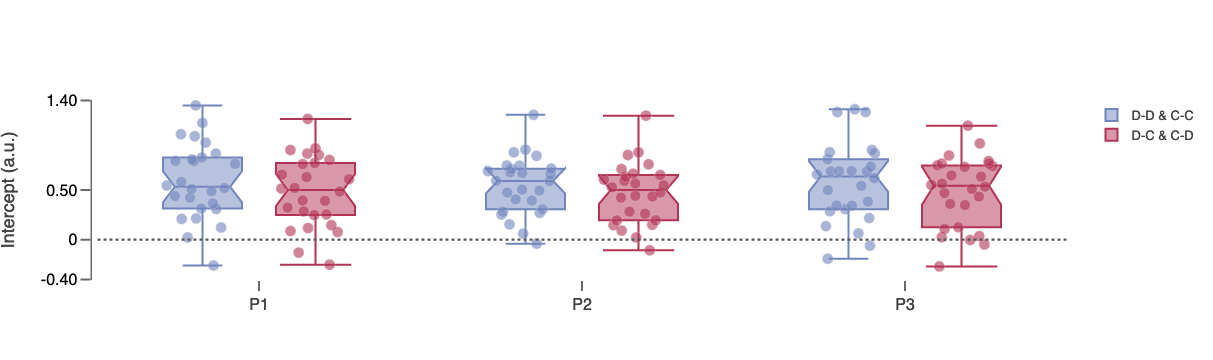

In [88]:
fig = go.Figure()
data = log_regpre_deci_params
dat = log_regpre_deci_params.loc[(log_regpre_deci_params.cong_stim_DV == 0),:]

fig.add_trace(go.Box( #boxplot for the condition were one stimuli is followed by another from the same category
    y=dat['intercept'],x=dat['nrep'],boxpoints='all',
    jitter=0.99, # add some jitter for a better separation between points
    pointpos=0,
        marker=dict(color='#2A88D4', size=11, opacity=0.6, line=dict(color='#f2f2f2', width=.4)),
    notched=True, notchwidth=0.15,
    name='D-D & C-C', # Stimuli follwed by one of the same category (D-D or C-C)
    marker_color='#7185bd')) 

dat = log_regpre_deci_params.loc[(log_regpre_deci_params.cong_stim_DV == 1),:]
fig.add_trace(go.Box( #boxplot for the condition were one stimuli is followed by another from a different category
    y=dat['intercept'], x=dat['nrep'], boxpoints='all', pointpos=0, jitter=0.99,
    whiskerwidth=0.9,
    marker=dict(color='#FA920A', size=11, opacity=0.6, line=dict(color='#f2f2f2', width=.4)),
    notched=True, notchwidth=0.15, 
    name='D-C & C-D', # Stimuli follwed by one of the different category (D-C or C-D)
    marker_color='#b23354'))

fig.update_layout(boxmode='group',)
fig.update_layout(template='plotly_white', xaxis=dict(showgrid=False),
    yaxis=dict(gridcolor='white'))

fig.update_xaxes(showline=False, linewidth=1.5, linecolor='#696969')
fig.update_yaxes(showline=True, linewidth=1.5, linecolor='#696969',
                 tickfont=dict(family='Balto, sans-serif', color='#000000', size=16))
fig.update_xaxes(tickvals = [0, 1, 2], ticktext=['P1', 'P2', 'P3'], 
                 tickangle=0, tickfont=dict(family='Balto, sans-serif', color='#424242', size=16))
fig.update_yaxes(tickvals= [-.40, 0.50, 1.4, 0], ticktext=['-0.40', '0.50', '1.40', '0', '0.80' ,'1.20', '1.40'])
fig.update_yaxes(ticks="outside", tickwidth=2, tickcolor='#696969', ticklen=10)
fig.update_xaxes(ticks="outside", tickwidth=2, tickcolor='#696969', ticklen=10)

fig.update_yaxes(showgrid=False)
fig.update_layout(
    yaxis_title="Intercept (a.u.)",
    font=dict(family="Balto, sans-serif",size=15,color= "#424242"))

fig.update_layout(
    legend=dict(traceorder="normal", font=dict(family="Balto, sans-serif",size=13,color="#424242")))

fig['layout']['yaxis'].update(range=[-.405, 1.405])

fig.update_yaxes(zeroline=False, zerolinewidth=0, zerolinecolor='Black')
fig.add_shape(type="line", xref="x", yref="y", x0=-0.5, y0=0, x1=2.5, y1=0, 
              line=dict(color="#595858", width=2.2, dash="dot",))

fig.show()

<font size="4"> Statistical tests for Inercept

In [53]:
#Checking statistical differences in Intercept between the number of repetitions 
# & the orientation of the previous stimulus

pg.rm_anova(dv = 'intercept', within = ['nrep', 'pre_stim'], subject = 'npar', 
            data=log_regpre_deci_params, detailed = True, correction = True)

# no differences in the intercept

,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,np2,eps
0,nrep,0.020666,2,52,0.010333,0.516653,0.599543,0.598899,0.019484,0.996376
1,pre_stim,0.349316,1,26,0.349316,8.969096,0.005960,0.005960,0.256486,1.000000
2,nrep * pre_stim,0.005757,2,52,0.002878,0.762662,0.471569,0.460285,0.028497,0.907134


In [54]:
pg.pairwise_ttests(dv='intercept', within=['pre_stim', 'nrep'], subject='npar', 
                   padjust='bonf', effsize = 'cohen', data=log_regpre_deci_params) 

,Contrast,pre_stim,A,B,Paired,Parametric,T,dof,Tail,p-unc,p-corr,p-adjust,BF10,cohen
0,pre_stim,-,0,1,True,True,2.994845,26.0,two-sided,0.005960,NaN,NaN,7.235,0.278307
1,nrep,-,0,1,True,True,0.977335,26.0,two-sided,0.337410,1.0,bonf,0.314,0.085460
2,nrep,-,0,2,True,True,0.649050,26.0,two-sided,0.521999,1.0,bonf,0.247,0.048439
3,nrep,-,1,2,True,True,-0.373029,26.0,two-sided,0.712151,1.0,bonf,0.217,-0.031116
4,pre_stim * nrep,0,0,1,True,True,1.271739,26.0,two-sided,0.214724,1.0,bonf,0.42,0.126499
5,pre_stim * nrep,0,0,2,True,True,0.815741,26.0,two-sided,0.422059,1.0,bonf,0.276,0.064534
6,pre_stim * nrep,0,1,2,True,True,-0.532817,26.0,two-sided,0.598686,1.0,bonf,0.232,-0.050571
7,pre_stim * nrep,1,0,1,True,True,0.447472,26.0,two-sided,0.658240,1.0,bonf,0.223,0.038672
8,pre_stim * nrep,1,0,2,True,True,0.344832,26.0,two-sided,0.732995,1.0,bonf,0.215,0.027723
9,pre_stim * nrep,1,1,2,True,True,-0.118930,26.0,two-sided,0.906245,1.0,bonf,0.205,-0.008887


In [55]:
# post-hoc t-test for P1

dat= log_regpre_deci_params.loc[log_regpre_deci_params.nrep==0]
pg.pairwise_ttests(dv='intercept', within=['pre_stim'], subject='npar', 
                   padjust='bonf', effsize = 'cohen', data=dat) 

,Contrast,A,B,Paired,Parametric,T,dof,Tail,p-unc,BF10,cohen
0,pre_stim,0.0,1.0,True,True,3.001301,26.0,two-sided,0.005867,7.332,0.294823


In [56]:
# post-hoc t-test for P2

dat= log_regpre_deci_params.loc[log_regpre_deci_params.nrep==1]
pg.pairwise_ttests(dv='intercept', within=['pre_stim'], subject='npar', 
                   padjust='bonf', effsize = 'cohen', data=dat) 

,Contrast,A,B,Paired,Parametric,T,dof,Tail,p-unc,BF10,cohen
0,pre_stim,0.0,1.0,True,True,2.830166,26.0,two-sided,0.008852,5.168,0.267804


In [57]:
# post-hoc t-test for P3

dat= log_regpre_deci_params.loc[log_regpre_deci_params.nrep==2]
pg.pairwise_ttests(dv='intercept', within=['pre_stim'], subject='npar', 
                   padjust='bonf', effsize = 'cohen', data=dat) 

,Contrast,A,B,Paired,Parametric,T,dof,Tail,p-unc,BF10,cohen
0,pre_stim,0.0,1.0,True,True,2.483398,26.0,two-sided,0.019786,2.638,0.248507


<font size="5"> _Figure 5 C & D. Physical similarity between consecutive samples._

<font size="5"> _5C. Beta Weight._

Logisitc regression model with the physical similarity with previous sample

In [89]:
formula = "deci ~ dv"

log_regpre_orient_params = dflong_seq.groupby(['npar', 'nrep', 'cong_stim_OV']).apply(log_reg_fit, formula)
log_regpre_orient_params.reset_index(inplace = True)
log_regpre_orient_params.head()

,npar,nrep,cong_stim_OV,level_3,intercept,weight,PSE
0,1,0,0,0,0.823485,0.986368,-0.834866
1,1,0,1,0,0.890689,0.737549,-1.207634
2,1,1,0,0,0.558394,1.237056,-0.451389
3,1,1,1,0,0.555573,0.847831,-0.655287
4,1,2,0,0,0.515158,1.172976,-0.439189


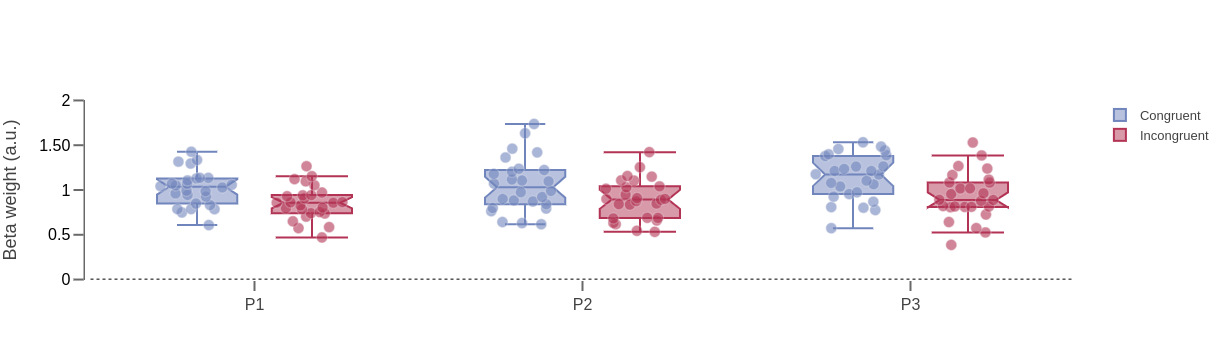

In [90]:
# Stimulus following one similar orientated (do not differ in many degrees) are weighted less than others
# preceded by stimuli from distant orientations.

fig = go.Figure()
data = log_regpre_orient_params

dat = log_regpre_orient_params.loc[(log_regpre_orient_params['cong_stim_OV'] == 0),:]
fig.add_trace(go.Box( #boxplot for the condition were one stimuli is followed by another similar oriented
    y=dat['weight'], x=dat['nrep'], boxpoints='all',
    jitter=0.99, # add some jitter for a better separation between points
    pointpos=0,
        marker=dict(color='#3FBFAA', size=11, opacity=0.6, line=dict(color='#f2f2f2', width=.4)),
    notched=True, notchwidth=0.15,
    name='Congruent', # Stimuli followed by another similar in orientation
    marker_color='#7185bd'))

dat = log_regpre_orient_params.loc[(log_regpre_orient_params['cong_stim_OV'] == 1),:]
fig.add_trace(go.Box( #condition for samples that follow stimuli pysichaly similar
    y=dat['weight'], x=dat['nrep'], boxpoints='all', pointpos=0, jitter=0.99,
    whiskerwidth=0.9,
    marker=dict(color='#9F68E3', size=11, opacity=0.6, line=dict(color='#f2f2f2', width=.4)),
    notched=True, notchwidth=0.15, 
    name='Incongruent', # Stimuli followed by another very different in orientation
    marker_color='#b23354'))

fig.update_layout(boxmode='group',)
fig.update_layout(template='plotly_white', xaxis=dict(showgrid=False),
    yaxis=dict(gridcolor='white'))

fig.update_xaxes(showline=False, linewidth=1.5, linecolor='#696969')
fig.update_yaxes(showline=True, linewidth=1.5, linecolor='#696969',
                 tickfont=dict(family='Balto, sans-serif', color='#000000', size=16))
fig.update_xaxes(tickvals = [0, 1, 2], ticktext=['P1', 'P2', 'P3'], 
                 tickangle=0, tickfont=dict(family='Balto, sans-serif', color='#424242', size=16))
fig.update_yaxes(tickvals= [0, .5, 1, 1.50, 2], ticktext=['0', '0.5', '1', '1.50', '2'])
fig.update_yaxes(ticks="outside", tickwidth=2, tickcolor='#696969', ticklen=10)
fig.update_xaxes(ticks="outside", tickwidth=2, tickcolor='#696969', ticklen=10)

fig.update_yaxes(showgrid=False)
fig.update_layout(
    yaxis_title="Beta weight (a.u.)",
    font=dict(family="Balto, sans-serif", size=15, color= "#424242"))

fig.update_layout(
    legend=dict(traceorder="normal", font=dict(family="Balto, sans-serif",size=13,color="#424242")))

fig['layout']['yaxis'].update(range=[-.005, 2.005])

fig.update_yaxes(zeroline=False, zerolinewidth=0, zerolinecolor='Black')
fig.add_shape(type="line", xref="x", yref="y", x0=-0.5, y0=0, x1=2.5, y1=0, line=dict(
                color="#595858", width=2.2, dash="dot",))

fig.show()

<font size="4"> Statistical tests for Beta Weight

In [92]:
# Checking statistical differences in 
# Weight between the number of repetitions & the orientation of the previous stimulus

pg.rm_anova(dv = 'weight', within = ['nrep', 'cong_stim_OV'], subject = 'npar', 
            data=log_regpre_orient_params, detailed = True, correction = True)

,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,np2,eps
0,nrep,0.257873,2,50,0.128937,7.643737,0.001269,0.001736,0.234156,0.925437
1,cong_stim_OV,1.206203,1,25,1.206203,11.904366,0.002000,0.002000,0.322573,1.000000
2,nrep * cong_stim_OV,0.018020,2,50,0.009010,1.057409,0.354993,0.351333,0.040580,0.929771


In [61]:
#post-hoc t-test
pg.pairwise_ttests(dv='weight', within=['nrep', 'pre_orient'], subject='npar', padjust='bonf', 
                   effsize = 'cohen',interaction=False, data=log_regpre_orient_params) 

,Contrast,A,B,Paired,Parametric,T,dof,Tail,p-unc,p-corr,p-adjust,BF10,cohen
0,nrep,0.0,1.0,True,True,-1.125617,26.0,two-sided,0.270611,0.811834,bonf,0.361,-0.160350
1,nrep,0.0,2.0,True,True,-4.335024,26.0,two-sided,0.000194,0.000583,bonf,145.935,-0.542633
2,nrep,1.0,2.0,True,True,-3.548843,26.0,two-sided,0.001498,0.004494,bonf,23.891,-0.316516
3,pre_orient,0.0,1.0,True,True,-6.280211,26.0,two-sided,0.000001,NaN,NaN,1.503e+04,-1.044517


Post-hoc t-test to look for interactions within categories

In [62]:
# post-hoc t-test for P1

dat = log_regpre_orient_params.loc[log_regpre_orient_params.nrep == 0]
pg.pairwise_ttests(dv='weight', within=['pre_orient'], subject='npar', padjust='bonf', 
                   effsize = 'cohen',interaction=False, data=dat) 

,Contrast,A,B,Paired,Parametric,T,dof,Tail,p-unc,BF10,cohen
0,pre_orient,0.0,1.0,True,True,-5.305021,26.0,two-sided,0.000015,1474.949,-1.105405


In [63]:
# post-hoc t-test for P2

dat = log_regpre_orient_params.loc[log_regpre_orient_params.nrep == 1]
pg.pairwise_ttests(dv='weight', within=['pre_orient'], subject='npar', padjust='bonf', 
                   effsize = 'cohen',interaction=False, data=dat) 

,Contrast,A,B,Paired,Parametric,T,dof,Tail,p-unc,BF10,cohen
0,pre_orient,0.0,1.0,True,True,-5.316472,26.0,two-sided,0.000015,1515.975,-0.893998


In [64]:
# post-hoc t-test for P3

dat = log_regpre_orient_params.loc[log_regpre_orient_params.nrep == 2]
pg.pairwise_ttests(dv='weight', within=['pre_orient'], subject='npar', padjust='bonf', 
                   effsize = 'cohen',interaction=False, data=dat) 

,Contrast,A,B,Paired,Parametric,T,dof,Tail,p-unc,BF10,cohen
0,pre_orient,0.0,1.0,True,True,-5.988884,26.0,two-sided,0.000003,7548.418,-0.959297


<font size="5"> _5D. Intercept._

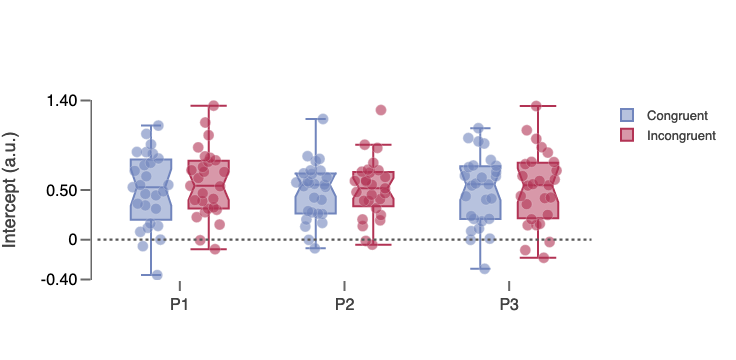

In [65]:
fig = go.Figure()

data = log_regpre_orient_params
dat = log_regpre_orient_params.loc[(log_regpre_orient_params.pre_orient == 0),:]

fig.add_trace(go.Box(
    y=dat['intercept'], x=dat['nrep'], boxpoints='all',
    jitter=0.99, # add some jitter for a better separation between points
    pointpos=0,
        marker=dict(color='#3FBFAA',size=11,opacity=0.6,line=dict(color='#f2f2f2', width=.4)),
    notched=True, notchwidth=0.15,
    name='Congruent', # Stimuli followed by another pyshically similar
    marker_color='#7185bd'))

dat = log_regpre_orient_params.loc[(log_regpre_orient_params.pre_orient == 1),:]
fig.add_trace(go.Box(
    y=dat['intercept'], x=dat['nrep'], boxpoints='all', pointpos=0, jitter=0.99,
    whiskerwidth=0.9,
    marker=dict(
        color='#9F68E3', size=11, opacity=0.6, line=dict(color='#f2f2f2', width=.4) ),
    notched=True, notchwidth=0.15, 
    name='Incongruent', # Stimuli followed by another very different in orientation
    marker_color='#b23354'))

fig.update_layout(boxmode='group',)
fig.update_layout(template='plotly_white', xaxis=dict(showgrid=False),
    yaxis=dict(gridcolor='white'))

fig.update_xaxes(showline=False, linewidth=1.5, linecolor='#696969')
fig.update_yaxes(showline=True, linewidth=1.5, linecolor='#696969',
                 tickfont=dict(family='Balto, sans-serif', color='#000000', size=16))

fig.update_xaxes(tickvals = [0, 1, 2], ticktext=['P1', 'P2', 'P3'], 
                 tickangle=0, tickfont=dict(family='Balto, sans-serif', color='#424242', size=16))
fig.update_yaxes(tickvals= [-.40, 0.50, 1.4, 0], ticktext=['-0.40', '0.50', '1.40', '0', '0.80' ,'1.20', '1.40'])
fig.update_yaxes(ticks="outside", tickwidth=2, tickcolor='#696969', ticklen=10)
fig.update_xaxes(ticks="outside", tickwidth=2, tickcolor='#696969', ticklen=10)

fig.update_yaxes(showgrid=False)
fig.update_layout(
    yaxis_title="Intercept (a.u.)",
    font=dict(family="Balto, sans-serif",size=15, color= "#424242"))

fig.update_layout(
    legend=dict(traceorder="normal", font=dict(family="Balto, sans-serif",size=13,color="#424242")))

fig['layout']['yaxis'].update(range=[-.405, 1.405])
fig.update_yaxes(zeroline=False, zerolinewidth=0, zerolinecolor='Black')
fig.add_shape(type="line", xref="x", yref="y", x0=-0.5, y0=0, x1=2.5, y1=0, line=dict(
                color="#595858", width=2.2, dash="dot",))

fig.show()

<font size="4"> Statistical tests for Intercept

In [66]:
#statistical test in Weight between the number of repetitions & the orientation of the previous stimulus

pg.rm_anova(dv = 'intercept', within = ['nrep', 'pre_orient'], subject = 'npar', 
            data=log_regpre_orient_params, detailed = True, correction = True)

,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,np2,eps
0,nrep,0.039290,2,52,0.019645,1.015189,0.369402,0.369034,0.037578,0.993656
1,pre_orient,0.055587,1,26,0.055587,2.131919,0.156239,0.156239,0.075783,1.000000
2,nrep * pre_orient,0.018495,2,52,0.009247,2.246483,0.115940,0.123065,0.079531,0.881712


<font size="5"> _Supplementary Figure 1A. Beta Weight for physical similarity between stimuli samples and previous decisions._

Logisitc regression model with congruency with stimuli sample by each presentation

In [516]:
dflong_seq.head(4)

,npar,subj,nblock,ntrial,nrep,stim_cond,cond-1,cong_deci,cong_stim,cond,deci-2,deci-1,deci,corr-1,correct,RT,stim,dv,orient,ov,abs_diffDV,cong_stim_DV,stim_cat_OV,abs_diffOV,cong_stim_OV
1,1,p03,0,0,0,D,0,I,I,1,0,0,1,0,1,0.735,d2,0.233015,117.742827,0.383493,0.324912,0,1,1,0
2,1,p03,0,0,0,C,0,C,C,1,0,0,1,0,1,0.735,d3,-0.101612,69.786259,0.550806,0.334626,1,1,1,0
3,1,p03,0,0,0,C,0,C,C,1,0,0,1,0,1,0.735,d4,-0.280384,163.808634,-0.640192,0.178772,0,0,0,1
4,1,p03,0,0,0,D,0,I,I,1,0,0,1,0,1,0.735,d5,0.738727,50.878652,0.130637,1.019110,1,1,1,1


In [1]:
ds = dflong.loc[dflong.nrep != 0]

NameError: name 'dflong' is not defined

In [23]:
formula = "deci ~ dv"
log_reg_cong_stim = dflong.groupby(['npar', 'cong_deci', 'stim_cond']).apply(log_reg_fit, formula) 
log_reg_cong_stim.reset_index(inplace = True)
log_reg_cong_stim.head(5)

,npar,cong_deci,stim_cond,level_3,intercept,weight,PSE
0,1,C,C,0,-0.991845,0.992293,0.999548
1,1,C,D,0,1.401623,0.609015,-2.301459
2,1,I,C,0,1.238741,0.746868,-1.658581
3,1,I,D,0,-1.096536,0.885431,1.238420
4,2,C,C,0,-0.827145,0.812679,1.017800


In [25]:
dat.head()

,npar,cong_deci,stim_cond,level_3,intercept,weight,PSE
0,1,C,C,0,-0.991845,0.992293,0.999548
1,1,C,D,0,1.401623,0.609015,-2.301459
2,1,I,C,0,1.238741,0.746868,-1.658581
3,1,I,D,0,-1.096536,0.885431,1.238420
4,2,C,C,0,-0.827145,0.812679,1.017800


In [1]:
%matplotlib qt
sns.set(font_scale = 1.5, style = 'ticks') 
dat = log_reg_cong_stim
ort = "v"; 
pal = "Set2"
# define variables to plot
dx = "cong_deci"; dy = "weight"; ort = "v"; pal = pal; sigma = .5

g = sns.FacetGrid(dat ,  row= 'stim_cond', height= 3.5, aspect=.95,margin_titles=True) # col="nrep",
g.set(ylim=[-1.5,3], yticks=[-1, 0, 1, 2, 3])
#g.tight_layout()

g.map_dataframe(sns.lineplot, x = dx, y= dy, data=dat, units= "npar" , estimator=None, color = 'grey',linewidth = 0.5, zorder = 1)
g.map_dataframe(sns.violinplot, x = dx, y = dy,  palette = pal,bw = .5, cut = 0.,scale = "area", width = .6, inner = None, orient = ort, linewidth = 0, zorder = 2)
g.map_dataframe(sns.stripplot, x = dx, y = dy, data = dat,  color = "black", edgecolor = "white",size = 6, linewidth = 0.6, jitter = 1, orient = ort)
g.map_dataframe(sns.boxplot, x = dx, y = dy, data = dat, color = "black", width = .15, zorder = 3, showcaps = True,  showmeans=True,meanprops={"marker":"o",
                       "markerfacecolor":"white", 
                       "markeredgecolor":"black",
                      "markersize":"10"},
      boxprops = {'facecolor':'None', "zorder":2}, showfliers=True,
      whiskerprops = {'linewidth':2, "zorder":2}, 
      saturation = 0.1, orient = ort)


g.map_dataframe(sns.lineplot,x = dx, y= dy, data=dat, units= "npar" , estimator=None, color = 'grey',linewidth = 0.5)
sns.despine(offset = .5,  trim=True);
axes = g.axes.flatten()
#axes[0].set_title("P1",fontsize = 20);axes[1].set_title("P2",fontsize = 20);axes[2].set_title("P3",fontsize = 20)
axes[3].set_title("",fontsize = 20);axes[4].set_title("",fontsize = 20);axes[5].set_title("",fontsize = 20)

#g._margin_titles_texts[0].set_color("red")
g._margin_titles_texts[0].set_text("Cardinal")
g._margin_titles_texts[0].set_size("20")
g._margin_titles_texts[1].set_text("Diagonal")
g._margin_titles_texts[1].set_size("20")

#g.fig.subplots_adjust( top = -.85 )
  
# Set x-axis and y-axis labels
g.set_axis_labels( "" , "Weight (a.u.)", fontsize = 15 )
#g.tight_layout()


'''
# you can access different features of the plot nad panels using for loops
for (row_val, col_val), ax in g.axes_dict.items():
    if row_val == "Lunch" and col_val == "Female":
        ax.set_facecolor(".95")
    else:
        ax.set_facecolor((0, 0, 0, 0))
#g.savefig("facet_plot.png")
'''

NameError: name 'sns' is not defined

In [487]:
g.margin_title[0]


AttributeError: 'FacetGrid' object has no attribute 'margin_title'

In [ ]:
for margin_title in grid._margin_titles_texts:
    margin_title.set_color("red")

In [374]:
looking_outliers = log_reg_cong_stim.loc[log_reg_cong_stim.nrep == 2]
looking_outliers.tail(6)

,npar,cong_deci,nrep,cond,level_4,intercept,weight,PSE
298,28,I,2,0,0,0.020161,-1.803439,0.011179
299,28,I,2,1,0,1.689875,-2.225479,0.759331
304,29,C,2,0,0,0.004868,2.145449,-0.002269
305,29,C,2,1,0,0.956274,1.014332,-0.942763
310,29,I,2,0,0,0.197833,-2.262122,0.087455
311,29,I,2,1,0,0.379394,-1.449773,0.261692


In [515]:
fig = go.Figure()
fig = make_subplots(rows=1, cols=3, subplot_titles=(['P1','P2', 'P3']))
fig.update_yaxes(zeroline=False, zerolinewidth=0, zerolinecolor='Black')
#fig.add_shape(type="line", xref="x2", yref="y2", x0=-0.5, y0=0, x1=1.5, y1=0, line=dict(
#                color="#595858", width=2.2, dash="dot",))
#fig.add_shape(type="line", xref="x3", yref="y3", x0=-0.5, y0=0, x1=1.5, y1=0, line=dict(
#                color="#595858", width=2.2, dash="dot",))
#fig.add_shape(type="line", xref="x1", yref="y1", x0=-0.5, y0=0, x1=1.5, y1=0, line=dict(
#                color="#595858", width=2.2, dash="dot",))

dat = log_reg_cong_stim.loc[(log_reg_cong_stim.nrep == 0) & (log_reg_cong_stim.cond == 'C'),:] 
fig.add_trace(go.Box(y=dat['weight'], opacity = 0.8, x=dat['cong_deci'], boxpoints='all',
    jitter=.99, pointpos=0,marker=dict(color='#2A88D4',size=11,opacity=0.8,line=dict(color='#f2f2f2', width=.4)),
    notched=True, notchwidth=0.15,
    name='Cardinal', marker_color=' #ffbf00 '), row=1, col=1)

dat = log_reg_cong_stim.loc[(log_reg_cong_stim.nrep == 0) & (log_reg_cong_stim.cond == 'D'),:] 
fig.add_trace(go.Box( y=dat['weight'], x=dat['cong_deci'], opacity = 1, showlegend=False, boxpoints='all',
    jitter=.99, pointpos=0, marker=dict(color='#2A88D4',size=11,opacity=0.65,line=dict(color='#f2f2f2', width=.4)),
    notched=True, notchwidth=0.15, name='Diagonal', marker_color='#00acc1'), row=1, col=1)

dat = log_reg_cong_stim.loc[(log_reg_cong_stim.nrep == 1) & (log_reg_cong_stim.cond == 'C'),:] 
fig.add_trace(go.Box(y=dat['weight'], opacity = 0.8, x=dat['cong_deci'], showlegend=False,
    boxpoints='all', jitter=.99, 
    pointpos=0,marker=dict(color='#2A88D4',size=11,opacity=0.8,line=dict(color='#f2f2f2', width=.4)),
    notched=True, notchwidth=0.15,
    name='Cardinal', marker_color='  #ffbf00  '), row=1, col=2) 

dat = log_reg_cong_stim.loc[(log_reg_cong_stim.nrep == 1) & (log_reg_cong_stim.cond == 'D'),:] 
fig.add_trace(go.Box(y=dat['weight'], x=dat['cong_deci'], opacity = 1, boxpoints='all', jitter=.99, 
    pointpos=0,marker=dict(color='#2A88D4',size=11,opacity=0.65,line=dict(color='#f2f2f2', width=.4)),
    notched=True, notchwidth=0.15,
    name='Diagonal', marker_color='#00acc1'), row=1, col=2)

dat = log_reg_cong_stim.loc[(log_reg_cong_stim.nrep == 2) & (log_reg_cong_stim.cond == 'C'),:] 
fig.add_trace(go.Box(  y=dat['weight'], opacity = 0.8, x=dat['cong_deci'], showlegend=False,
    boxpoints='all', jitter=.99, 
    pointpos=0,marker=dict(color='#2A88D4',size=11,opacity=0.8,line=dict(color='#f2f2f2', width=.4)),
    notched=True, notchwidth=0.15,
    name='Cardinal', 
    marker_color=' #ffbf00 '), row=1, col=3) 

dat = log_reg_cong_stim.loc[(log_reg_cong_stim.nrep == 2) & (log_reg_cong_stim.cond == 'D'),:] 
fig.add_trace(go.Box( 
    y=dat['weight'], x=dat['cong_deci'], opacity = 1, showlegend=False,
    boxpoints='all', jitter=.99, 
    pointpos=0,marker=dict(color='#2A88D4',size=11,opacity=0.65,line=dict(color='#f2f2f2', width=.4)),
    notched=True, notchwidth=0.15,
    name='Diagonal', marker_color='#00acc1'), row=1, col=3)

fig.update_layout(boxgroupgap=0)
fig.update_layout(template='plotly_white', xaxis=dict(showgrid=False),
    yaxis=dict(gridcolor='white'))

fig.update_xaxes(showline=False, linewidth=1.5, linecolor='#696969')
fig.update_yaxes(showline=True, linewidth=1.5, linecolor='#696969',
                 tickfont=dict(family='Balto, sans-serif', color='#000000', size=16))
fig.update_xaxes(tickvals = [0, 1], ticktext=['Congruent', 'Incongruent'], 
                 tickangle=0, tickfont=dict(family='Balto, sans-serif', color='#424242', size=16))
fig.update_yaxes(ticks="outside", tickwidth=2, tickcolor='#696969', ticklen=10)
fig.update_xaxes(ticks="outside", tickwidth=2, tickcolor='#696969', ticklen=10)
fig.update_yaxes(showgrid=False)

fig.update_layout(yaxis_title="Beta weight (a.u.)",
    font=dict(family="Balto, sans-serif", size=15, color= "#424242"))
fig.update_layout(
    legend=dict(traceorder="normal", font=dict(family="Balto, sans-serif",size=13,color="#424242")))

#fig['layout']['yaxis1'].update(range=[-1.005, 2.51]); fig['layout']['yaxis2'].update(range=[-1.005, 2.51])
#fig['layout']['yaxis3'].update(range=[-1.005, 2.51])

fig.show()

AttributeError: 'DataFrame' object has no attribute 'cond'

<font size="4"> Statistical tests for Beta Weight

In [483]:
dat = log_reg_cong_stim.loc[(log_reg_cong_stim.stim_cond == 'C') & (log_reg_cong_stim.nrep != 0)]
pg.rm_anova(dv = 'weight', within = ['nrep', 'cong_deci'], subject = 'npar', data=dat, detailed = True, correction = True)

,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,np2,eps
0,nrep,0.206328,1,25,0.206328,0.490596,0.490129,0.490129,0.019246,1.0
1,cong_deci,4.849159,1,25,4.849159,8.737506,0.006711,0.006711,0.258985,1.0
2,nrep * cong_deci,0.000476,1,25,0.000476,0.001535,0.969058,0.969058,0.000061,1.0


In [71]:
dat = log_reg_cong_stim.loc[log_reg_cong_stim.cond == 'D']
pg.pairwise_ttests(dv='weight', within= ['nrep', 'cong_stim'], subject='npar', padjust='bonf', 
                   tail='two-sided', interaction=True, effsize = 'cohen', data=dat) 

,Contrast,nrep,A,B,Paired,Parametric,T,dof,Tail,p-unc,p-corr,p-adjust,BF10,cohen
0,nrep,-,0,1,True,True,11.070187,26.0,two-sided,2.450018e-11,7.350053e-11,bonf,3.736e+08,2.233195
1,nrep,-,0,2,True,True,8.199577,26.0,two-sided,1.110960e-08,3.332881e-08,bonf,1.173e+06,1.874948
2,nrep,-,1,2,True,True,-0.839986,26.0,two-sided,4.085745e-01,1.000000e+00,bonf,0.281,-0.120581
3,cong_stim,-,C,I,True,True,-0.430513,26.0,two-sided,6.703707e-01,NaN,NaN,0.222,-0.115840
4,nrep * cong_stim,0,C,I,True,True,-1.305173,26.0,two-sided,2.032672e-01,6.098015e-01,bonf,0.437,-0.382671
5,nrep * cong_stim,1,C,I,True,True,0.286044,26.0,two-sided,7.771112e-01,1.000000e+00,bonf,0.212,0.081996
6,nrep * cong_stim,2,C,I,True,True,-0.097211,26.0,two-sided,9.233044e-01,1.000000e+00,bonf,0.205,-0.025444


In [72]:
dat = log_reg_cong_stim.loc[(log_reg_cong_stim.nrep == 0) & (log_reg_cong_stim.cong_stim == 'C'),:]
pg.rm_anova(dv = 'weight', within = ['cond'], subject = 'npar', data=dat, detailed = True, correction = True)

,Source,SS,DF,MS,F,p-unc,np2,eps
0,cond,3.517647,1,3.517647,19.769313,0.000145,0.431934,1.0
1,Error,4.626302,26,0.177935,NaN,NaN,NaN,NaN


<font size="5"> _Supplementary Figure 1B. Intercept for Physical similarity between stimuli samples and previous decisions._

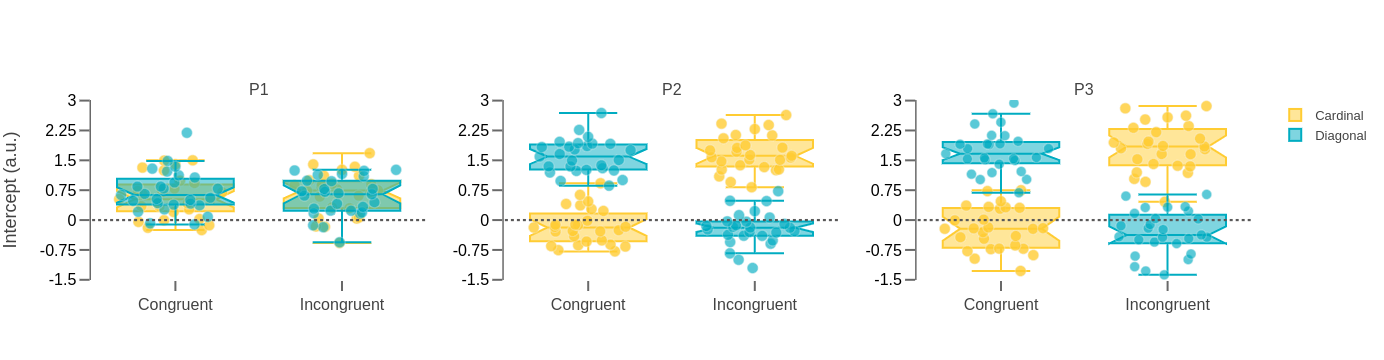

In [73]:
fig = go.Figure()
fig = make_subplots(rows=1, cols=3, subplot_titles=(['P1','P2', 'P3']))
fig.update_yaxes(zeroline=False, zerolinewidth=0, zerolinecolor='Black')
fig.add_shape(type="line", xref="x2", yref="y2", x0=-0.5, y0=0, x1=1.5, y1=0, line=dict(
                color="#595858", width=2.2, dash="dot",))
fig.add_shape(type="line", xref="x3", yref="y3", x0=-0.5, y0=0, x1=1.5, y1=0, line=dict(
                color="#595858", width=2.2, dash="dot",))
fig.add_shape(type="line", xref="x1", yref="y1", x0=-0.5, y0=0, x1=1.5, y1=0, line=dict(
                color="#595858", width=2.2, dash="dot",))

dat = log_reg_cong_stim.loc[(log_reg_cong_stim.nrep == 0) & (log_reg_cong_stim.cond == 'C'),:] 
fig.add_trace(go.Box( 
    y=dat['intercept'], opacity = 0.8, x=dat['cong_stim'], boxpoints='all', jitter=.99, 
    pointpos=0,marker=dict(color='#2A88D4',size=11,opacity=0.8,line=dict(color='#f2f2f2', width=.4)),
    notched=True, notchwidth=0.15,
    name='Cardinal', marker_color=' #ffbf00 '), row=1, col=1)

dat = log_reg_cong_stim.loc[(log_reg_cong_stim.nrep == 0) & (log_reg_cong_stim.cond == 'D'),:] 
fig.add_trace(go.Box(y=dat['intercept'], x=dat['cong_stim'], opacity = 1, showlegend=False,
    boxpoints='all', jitter=.99, 
    pointpos=0,marker=dict(color='#2A88D4',size=11,opacity=0.65,line=dict(color='#f2f2f2', width=.4)),
    notched=True, notchwidth=0.15,
    name='Diagonal', marker_color='#00acc1'), row=1, col=1)

dat = log_reg_cong_stim.loc[(log_reg_cong_stim.nrep == 1) & (log_reg_cong_stim.cond == 'C'),:] 
fig.add_trace(go.Box(y=dat['intercept'], opacity = 0.8, x=dat['cong_stim'], showlegend=False,
    boxpoints='all', jitter=.99, 
    pointpos=0,marker=dict(color='#2A88D4',size=11,opacity=0.8,line=dict(color='#f2f2f2', width=.4)),
    notched=True, notchwidth=0.15,
    name='Cardinal', marker_color='  #ffbf00  '), row=1, col=2) 

dat = log_reg_cong_stim.loc[(log_reg_cong_stim.nrep == 1) & (log_reg_cong_stim.cond == 'D'),:] 
fig.add_trace(go.Box(y=dat['intercept'], x=dat['cong_stim'], opacity = 1, boxpoints='all', jitter=.99, 
    pointpos=0,marker=dict(color='#2A88D4',size=11,opacity=0.65,line=dict(color='#f2f2f2', width=.4)),
    notched=True, notchwidth=0.15,
    name='Diagonal', marker_color='#00acc1'), row=1, col=2) 

dat = log_reg_cong_stim.loc[(log_reg_cong_stim.nrep == 2) & (log_reg_cong_stim.cond == 'C'),:] 
fig.add_trace(go.Box( 
    y=dat['intercept'], opacity = 0.8, x=dat['cong_stim'], showlegend=False,
    boxpoints='all',
    jitter=.99, # add some jitter for a better separation between points
    pointpos=0,marker=dict(color='#2A88D4',size=11,opacity=0.8,line=dict(color='#f2f2f2', width=.4)),
    #boxmean='sd',
    notched=True, notchwidth=0.15,
    name='Cardinal',
    marker_color=' #ffbf00 '), row=1, col=3) 

dat = log_reg_cong_stim.loc[(log_reg_cong_stim.nrep == 2) & (log_reg_cong_stim.cond == 'D'),:] 
fig.add_trace(go.Box( y=dat['intercept'], x=dat['cong_stim'], opacity = 1, showlegend=False,
    boxpoints='all', jitter=.99, # add some jitter for a better separation between points
    pointpos=0,marker=dict(color='#2A88D4',size=10,opacity=0.65,line=dict(color='#f2f2f2', width=.4)),
    notched=True, notchwidth=0.15,
    name='Diagonal', marker_color='#00acc1'), row=1, col=3)

fig.update_layout(boxgroupgap=0)
fig.update_layout(template='plotly_white', xaxis=dict(showgrid=False),
    yaxis=dict(gridcolor='white'))

fig.update_xaxes(showline=False, linewidth=1.5, linecolor='#696969')
fig.update_yaxes(showline=True, linewidth=1.5, linecolor='#696969',
                 tickfont=dict(family='Balto, sans-serif', color='#000000', size=16))
fig.update_xaxes(tickvals = [0, 1], ticktext=['Congruent', 'Incongruent'], 
                 tickangle=0, tickfont=dict(family='Balto, sans-serif', color='#424242', size=16))
fig.update_yaxes(tickvals= [-1.5,-0.75, 0, 0.75, 1.5, 2.25, 3], 
                 ticktext=['-1.5','-0.75', '0', '0.75', '1.5' ,'2.25', '3'])
fig.update_yaxes(ticks="outside", tickwidth=2, tickcolor='#696969', ticklen=10)
fig.update_xaxes(ticks="outside", tickwidth=2, tickcolor='#696969', ticklen=10)

fig.update_yaxes(showgrid=False)
fig.update_layout(
    yaxis_title="Intercept (a.u.)",
    font=dict(family="Balto, sans-serif", size=15, color= "#424242"))

fig.update_layout(
    legend=dict(traceorder="normal", font=dict(family="Balto, sans-serif",size=13,color="#424242")))

fig['layout']['yaxis1'].update(range=[-1.505, 3.015]); fig['layout']['yaxis2'].update(range=[-1.505, 3.015])
fig['layout']['yaxis3'].update(range=[-1.505, 3.015],)

fig.show()

<font size="4"> Statistical tests for Intercept

In [74]:
dat = log_reg_cong_stim.loc[log_reg_cong_stim.cond == 'D']
pg.rm_anova(dv = 'intercept', within = ['nrep', 'cong_stim'], subject = 'npar', 
            data=dat, detailed = True, correction = True)

,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,np2,eps
0,nrep,0.106604,2,52,0.053302,1.405071,2.545089e-01,2.548169e-01,0.051270,0.932192
1,cong_stim,71.439302,1,26,71.439302,342.787419,1.704312e-16,1.704312e-16,0.929499,1.000000
2,nrep * cong_stim,29.185073,2,52,14.592537,194.679087,7.104220e-25,8.008772e-21,0.882182,0.820243


In [75]:
dat = log_reg_cong_stim.loc[log_reg_cong_stim.cond == 'D']
pg.pairwise_ttests(dv='intercept', within= ['nrep', 'cong_stim'], subject='npar', padjust='bonf', 
                   tail='two-sided', interaction=True, effsize = 'cohen', data=dat) 

,Contrast,nrep,A,B,Paired,Parametric,T,dof,Tail,p-unc,p-corr,p-adjust,BF10,cohen
0,nrep,-,0,1,True,True,-1.423697,26.0,two-sided,1.664252e-01,4.992756e-01,bonf,0.502,-0.117921
1,nrep,-,0,2,True,True,-1.466176,26.0,two-sided,1.545916e-01,4.637747e-01,bonf,0.529,-0.133234
2,nrep,-,1,2,True,True,-0.365952,26.0,two-sided,7.173619e-01,1.000000e+00,bonf,0.217,-0.032899
3,cong_stim,-,C,I,True,True,18.514519,26.0,two-sided,1.704312e-16,NaN,NaN,3.044e+13,2.954235
4,nrep * cong_stim,0,C,I,True,True,1.250214,26.0,two-sided,2.223572e-01,6.670715e-01,bonf,0.411,0.268860
5,nrep * cong_stim,1,C,I,True,True,21.684017,26.0,two-sided,3.566698e-18,1.070009e-17,bonf,1.23e+15,4.279840
6,nrep * cong_stim,2,C,I,True,True,22.650209,26.0,two-sided,1.213097e-18,3.639292e-18,bonf,3.456e+15,3.767159


<font size="5"> _Figure 6A. Beta Weight for Categorical similarity between stimuli samples and previous decisions._

<font size="3"> _Logisitc regression model to plot Figure 6_

In [76]:
formula = "deci ~ dv"
log_reg_cong_deci = dflong.groupby(['npar', 'cong_deci', 'nrep', 'cond']).apply(log_reg_fit, formula) 
log_reg_cong_deci.reset_index(inplace = True)
log_reg_cong_deci.head()

,npar,cong_deci,nrep,cond,level_4,intercept,weight,PSE
0,1.0,C,0,C,0,0.195054,0.571804,-0.341120
1,1.0,C,0,D,0,0.530885,1.448131,-0.366600
2,1.0,C,1,C,0,-1.567359,0.202153,7.753317
3,1.0,C,1,D,0,1.644346,1.427259,-1.152101
4,1.0,C,2,C,0,-1.282753,0.670489,1.913161


Figure 6A

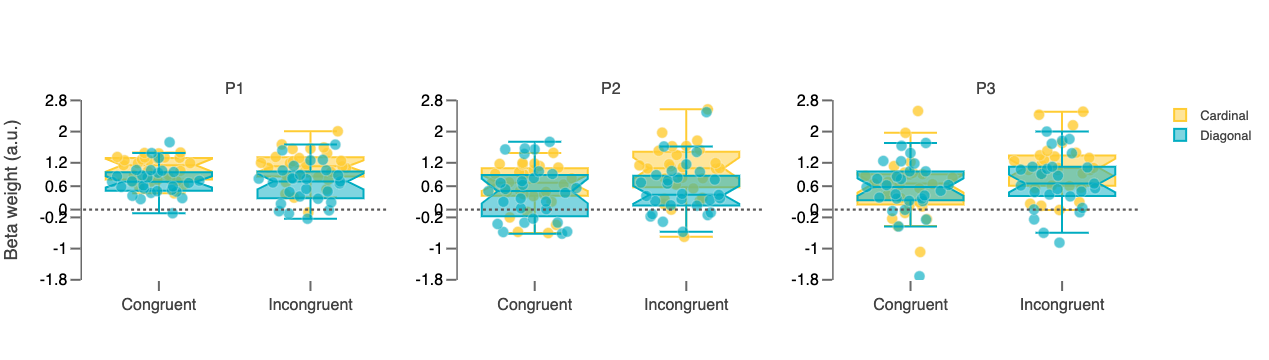

In [77]:
fig = go.Figure()
fig = make_subplots(rows=1, cols=3, subplot_titles=(['P1','P2', 'P3']))
fig.update_yaxes(zeroline=False, zerolinewidth=0, zerolinecolor='Black')
fig.add_shape(type="line", xref="x2", yref="y2", x0=-0.5, y0=0, x1=1.5, y1=0, line=dict(
                color="#595858", width=2.2, dash="dot",))
fig.add_shape(type="line", xref="x3", yref="y3", x0=-0.5, y0=0, x1=1.5, y1=0, line=dict(
                color="#595858", width=2.2, dash="dot",))
fig.add_shape(type="line", xref="x1", yref="y1", x0=-0.5, y0=0, x1=1.5, y1=0, line=dict(
                color="#595858", width=2.2, dash="dot",))

dat = log_reg_cong_deci.loc[(log_reg_cong_deci.nrep == 0) & (log_reg_cong_deci.cond == 'C'),:] 
fig.add_trace(go.Box(y=dat['weight'], x=dat['cong_deci'],showlegend=False, opacity = 0.8,
    boxpoints='all', jitter=.99, 
    pointpos=0,marker=dict(color='#2A88D4',size=11,opacity=0.8,line=dict(color='#f2f2f2', width=.4)),
    notched=True, notchwidth=0.15, name='Cardinal', 
    marker_color=' #ffbf00 '), row=1, col=1)

dat = log_reg_cong_deci.loc[(log_reg_cong_deci.nrep == 0) & (log_reg_cong_deci.cond == 'D'),:] 
fig.add_trace(go.Box(y=dat['weight'], x=dat['cong_deci'],showlegend=False, opacity = 1,
    boxpoints='all', jitter=.99,
    pointpos=0,marker=dict(color='#2A88D4',size=11,opacity=0.65,line=dict(color='#f2f2f2', width=.4)),
    notched=True, notchwidth=0.15, name='Diagonal',
    marker_color=' #00acc1 '), row=1, col=1)

dat = log_reg_cong_deci.loc[(log_reg_cong_deci.nrep == 1) & (log_reg_cong_deci.cond == 'C'),:]
fig.add_trace(go.Box(y=dat['weight'], x=dat['cong_deci'],showlegend=False, opacity = 0.8,
    boxpoints='all',
    jitter=.99, # add some jitter for a better separation between points
    pointpos=0,marker=dict(color='#2A88D4',size=11,opacity=0.8,line=dict(color='#f2f2f2', width=.4)),
    notched=True, notchwidth=0.15,
    name='Cardinal', marker_color=' #ffbf00 '), row=1, col=2)

dat = log_reg_cong_deci.loc[(log_reg_cong_deci.nrep == 1) & (log_reg_cong_deci.cond == 'D'),:]
fig.add_trace(go.Box(y=dat['weight'], x=dat['cong_deci'],showlegend=False, opacity = 1,
    boxpoints='all', jitter=.99,
    pointpos=0,marker=dict(color='#2A88D4',size=11,opacity=0.65,line=dict(color='#f2f2f2', width=.4)),
    notched=True, notchwidth=0.15,
    name='Diagonal', marker_color=' #00acc1 '), row=1, col=2)

dat = log_reg_cong_deci.loc[(log_reg_cong_deci.nrep == 2) & (log_reg_cong_deci.cond == 'C'),:]
fig.add_trace(go.Box(y=dat['weight'], x=dat['cong_deci'],showlegend=True, opacity = 0.8,
    boxpoints='all', jitter=.99, pointpos=0,
    marker=dict(color='#2A88D4',size=11,opacity=0.8,line=dict(color='#f2f2f2', width=.4)),
    notched=True, notchwidth=0.15,
    name='Cardinal', marker_color=' #ffbf00 '), row=1, col=3)

dat = log_reg_cong_deci.loc[(log_reg_cong_deci.nrep == 2) & (log_reg_cong_deci.cond == 'D'),:]
fig.add_trace(go.Box(y=dat['weight'], x=dat['cong_deci'], showlegend=True, opacity = 1,
    boxpoints='all', jitter=.99, pointpos=0,
    marker=dict(color='#2A88D4',size=11,opacity=0.65, line=dict(color='#f2f2f2', width=.4)),
    notched=True, notchwidth=0.15, name='Diagonal', marker_color='#00acc1'), row=1, col=3)

fig.update_layout(boxgroupgap=0)
fig.update_layout(template='plotly_white', xaxis=dict(showgrid=False),
    yaxis=dict(gridcolor='white'))

fig.update_xaxes(showline=False, linewidth=1.5, linecolor='#696969')
fig.update_yaxes(showline=True, linewidth=1.5, linecolor='#696969',
                 tickfont=dict(family='Balto, sans-serif', color='#000000', size=16))
fig.update_xaxes(tickvals = [0, 1], ticktext=['Congruent', 'Incongruent'], 
                 tickangle=0, tickfont=dict(family='Balto, sans-serif', color='#424242', size=16))
fig.update_yaxes(tickvals= [-1.8, -1, -.2, 0, 0.6, 1.2, 2, 2.8], 
                 ticktext=['-1.8','-1', '-0.2', '0', '0.6' ,'1.2', '2', '2.8'])
fig.update_yaxes(ticks="outside", tickwidth=2, tickcolor='#696969', ticklen=10)
fig.update_xaxes(ticks="outside", tickwidth=2, tickcolor='#696969', ticklen=10)

fig.update_yaxes(showgrid=False)
fig.update_layout(
    yaxis_title="Beta weight (a.u.)",
    font=dict(family="Balto, sans-serif", size=15, color= "#424242"))

fig.update_layout(legend=dict(traceorder="normal", font=dict(family="Balto, sans-serif",size=13,color="#424242")))

fig['layout']['yaxis1'].update(range=[-1.805, 2.81]); fig['layout']['yaxis2'].update(range=[-1.805, 2.81])
fig['layout']['yaxis3'].update(range=[-1.805, 2.81])

fig.show()

<font size="4"> Statistical tests for Beta Weight

In [78]:
dat = log_reg_cong_deci.loc[log_reg_cong_deci.cond == 'C']
pg.rm_anova(dv = 'weight', within = ['nrep', 'cong_deci'], subject = 'npar', 
            data=dat, detailed = True, correction = True)

,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,np2,eps
0,nrep,2.249762,2,52,1.124881,4.725408,0.013013,0.017580,0.153795,0.862711
1,cong_deci,3.756905,1,26,3.756905,8.257388,0.007982,0.007982,0.241040,1.000000
2,nrep * cong_deci,1.637936,2,52,0.818968,2.925429,0.062522,0.066848,0.101137,0.929404


In [79]:
dat = log_reg_cong_deci.loc[(log_reg_cong_deci.nrep == 2),:]
pg.pairwise_ttests(dv='weight', within= ['cond', 'cong_deci'], subject='npar', 
                   padjust='bonf', tail='two-sided', interaction=True, effsize = 'cohen', data=dat) 

,Contrast,cond,A,B,Paired,Parametric,T,dof,Tail,p-unc,p-corr,p-adjust,BF10,cohen
0,cond,-,C,D,True,True,1.041703,26.0,two-sided,0.307139,NaN,NaN,0.333,0.262851
1,cong_deci,-,C,I,True,True,-2.255165,26.0,two-sided,0.032768,NaN,NaN,1.746,-0.649987
2,cond * cong_deci,C,C,I,True,True,-2.574830,26.0,two-sided,0.016072,0.032143,bonf,3.134,-0.712635
3,cond * cong_deci,D,C,I,True,True,-1.132627,26.0,two-sided,0.267708,0.535417,bonf,0.363,-0.333281


In [80]:
dat = log_reg_cong_deci.loc[log_reg_cong_deci.cond == 'D']
pg.pairwise_ttests(dv='weight', within= ['nrep', 'cong_deci'], subject='npar', 
                   padjust='bonf', tail='two-sided', interaction=False, effsize = 'cohen', data=dat) 

,Contrast,A,B,Paired,Parametric,T,dof,Tail,p-unc,p-corr,p-adjust,BF10,cohen
0,nrep,0,1,True,True,1.954473,26.0,two-sided,0.061479,0.184437,bonf,1.058,0.499663
1,nrep,0,2,True,True,-0.003172,26.0,two-sided,0.997493,1.000000,bonf,0.204,-0.000868
2,nrep,1,2,True,True,-1.738290,26.0,two-sided,0.093991,0.281973,bonf,0.763,-0.377056
3,cong_deci,C,I,True,True,-0.926794,26.0,two-sided,0.362557,NaN,NaN,0.301,-0.234961


<font size="5"> _Figure 6B. Intercept for Categorical similarity between stimuli samples and previous decisions._

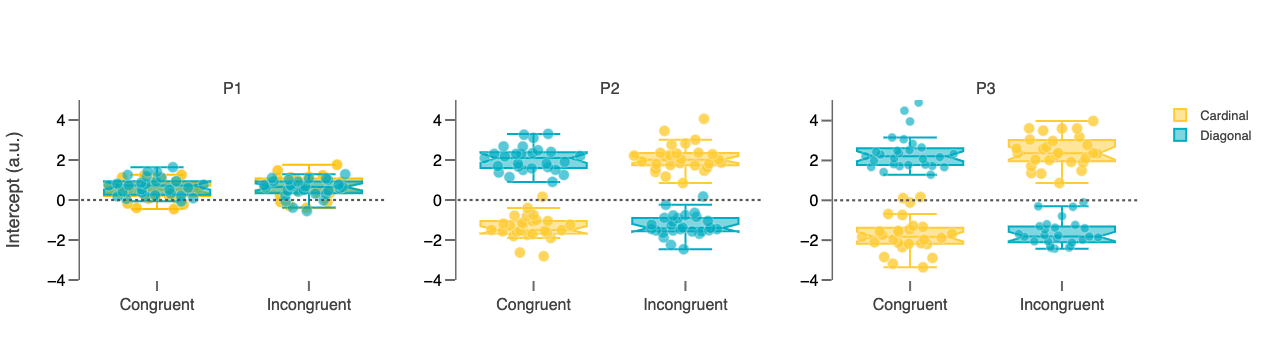

In [81]:
fig = go.Figure()
fig = make_subplots(rows=1, cols=3, subplot_titles=(['P1','P2', 'P3']))
fig.update_yaxes(zeroline=False, zerolinewidth=0, zerolinecolor='Black')

fig.add_shape(type="line", xref="x2", yref="y2", x0=-0.5, y0=0, x1=1.5, y1=0, line=dict(
                color="#595858", width=2.2, dash="dot",))
fig.add_shape(type="line", xref="x3", yref="y3", x0=-0.5, y0=0, x1=1.5, y1=0, line=dict(
                color="#595858", width=2.2, dash="dot",))
fig.add_shape(type="line", xref="x1", yref="y1", x0=-0.5, y0=0, x1=1.5, y1=0, line=dict(
                color="#595858", width=2.2, dash="dot",))

dat = log_reg_cong_deci.loc[(log_reg_cong_deci.nrep == 0) & (log_reg_cong_deci.cond == 'C'),:] 
fig.add_trace(go.Box(y=dat['intercept'], x=dat['cong_deci'],showlegend=False, opacity = 1,
    boxpoints='all', jitter=.99, 
    pointpos=0,marker=dict(color='#2A88D4',size=11,opacity=0.8,line=dict(color='#f2f2f2', width=.4)),
    notched=True, notchwidth=0.15,
    name='Cardinal', marker_color=' #ffbf00 '), row=1, col=1)

dat = log_reg_cong_deci.loc[(log_reg_cong_deci.nrep == 0) & (log_reg_cong_deci.cond == 'D'),:] 
fig.add_trace(go.Box(y=dat['intercept'], x=dat['cong_deci'],showlegend=False, opacity = 1,
    boxpoints='all',
    jitter=.99, pointpos=0,
    marker=dict(color='#2A88D4',size=11,opacity=0.65,line=dict(color='#f2f2f2', width=.4)),
    notched=True, notchwidth=0.15,
    name='Diagonal', marker_color=' #00acc1 '), row=1, col=1)

dat = log_reg_cong_deci.loc[(log_reg_cong_deci.nrep == 1) & (log_reg_cong_deci.cond == 'C'),:] 
fig.add_trace(go.Box(y=dat['intercept'], x=dat['cong_deci'],showlegend=False, opacity = 0.8,
    boxpoints='all', jitter=.99, # add some jitter for a better separation between points
    pointpos=0,marker=dict(color='#2A88D4',size=11,opacity=0.8,line=dict(color='#f2f2f2', width=.4)),
    notched=True, notchwidth=0.15, name='Cardinal', marker_color=' #ffbf00 '), row=1, col=2)

dat = log_reg_cong_deci.loc[(log_reg_cong_deci.nrep == 1) & (log_reg_cong_deci.cond == 'D'),:] 
fig.add_trace(go.Box(y=dat['intercept'], x=dat['cong_deci'],showlegend=False, opacity = 1, boxpoints='all',
    jitter=.99, # add some jitter for a better separation between points
    pointpos=0,marker=dict(color='#2A88D4',size=11,opacity=0.65,line=dict(color='#f2f2f2', width=.4)),
    notched=True, notchwidth=0.15,
    name='Diagonal', marker_color=' #00acc1 '), row=1, col=2)

dat = log_reg_cong_deci.loc[(log_reg_cong_deci.nrep == 2) & (log_reg_cong_deci.cond == 'C'),:]
fig.add_trace(go.Box(y=dat['intercept'], x=dat['cong_deci'],showlegend=True, opacity = 0.8, boxpoints='all',
    jitter=.99, # add some jitter for a better separation between points
    pointpos=0,marker=dict(color='#2A88D4',size=11,opacity=0.8,line=dict(color='#f2f2f2', width=.4)),
    notched=True, notchwidth=0.15,
    name='Cardinal',marker_color=' #ffbf00 '), row=1, col=3)

dat = log_reg_cong_deci.loc[(log_reg_cong_deci.nrep == 2) & (log_reg_cong_deci.cond == 'D'),:] 
fig.add_trace(go.Box(y=dat['intercept'], x=dat['cong_deci'], showlegend=True, opacity = 1,
    boxpoints='all', jitter=.99, # add some jitter for a better separation between points
    pointpos=0,marker=dict(color='#2A88D4',size=9,opacity=0.65,line=dict(color='#f2f2f2', width=.4)),
    notched=True, notchwidth=0.15,
    name='Diagonal', marker_color='#00acc1'), row=1, col=3)

fig.update_layout(boxgroupgap=0)
fig.update_layout(template='plotly_white', xaxis=dict(showgrid=False),
    yaxis=dict(gridcolor='white'))
fig.update_xaxes(showline=False, linewidth=1.5, linecolor='#696969')
fig.update_yaxes(showline=True, linewidth=1.5, linecolor='#696969',
                 tickfont=dict(family='Balto, sans-serif', color='#000000', size=16))
fig.update_xaxes(tickvals = [0, 1], ticktext=['Congruent', 'Incongruent'], 
                 tickangle=0, tickfont=dict(family='Balto, sans-serif', color='#424242', size=16))
fig.update_yaxes(ticks="outside", tickwidth=2, tickcolor='#696969', ticklen=10)
fig.update_xaxes(ticks="outside", tickwidth=2, tickcolor='#696969', ticklen=10)

fig.update_yaxes(showgrid=False)
fig.update_layout(yaxis_title="Intercept (a.u.)", 
                  font=dict(family="Balto, sans-serif",size=15, color= "#424242"))

fig.update_layout(legend=dict(traceorder="normal", 
                              font=dict(family="Balto, sans-serif",size=13,color="#424242")))

fig['layout']['yaxis1'].update(range=[-4, 5]); fig['layout']['yaxis2'].update(range=[-4, 5])
fig['layout']['yaxis3'].update(range=[-4, 5.034])

fig.show()

<font size="4"> Statistical tests for Intercept

In [82]:
# Cardinal condition
dat = log_reg_cong_deci.loc[log_reg_cong_deci.cond == 'C']

pg.rm_anova(dv = 'intercept', within = ['nrep', 'cong_deci'], subject = 'npar', 
            data=dat, detailed = True, correction = True)

,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,np2,eps
0,nrep,1.636823,2,52,0.818411,4.140423,2.144984e-02,2.596399e-02,0.137371,0.892744
1,cong_deci,275.743248,1,26,275.743248,258.756344,4.966187e-15,4.966187e-15,0.908694,1.000000
2,nrep * cong_deci,124.524859,2,52,62.262430,168.648626,1.856830e-23,1.277561e-16,0.866426,0.676656


In [83]:
# Diagonal condition
dat = log_reg_cong_deci.loc[log_reg_cong_deci.cond == 'D']

pg.rm_anova(dv = 'intercept', within = ['nrep', 'cong_deci'], subject = 'npar', 
            data=dat, detailed = True, correction = True)

,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,np2,eps
0,nrep,3.436114,2,52,1.718057,7.362840,1.529215e-03,2.454520e-03,0.220690,0.882641
1,cong_deci,265.394084,1,26,265.394084,205.854769,7.261261e-14,7.261261e-14,0.887861,1.000000
2,nrep * cong_deci,128.269370,2,52,64.134685,96.189332,3.360791e-18,5.051936e-13,0.787215,0.674975


In [84]:
dat1 = dat.loc[dat.nrep==2]
np.mean(dat1.intercept)

0.27519521493992277

In [85]:
dat = log_reg_cong_deci.loc[log_reg_cong_deci.cond == 'C']
pg.pairwise_ttests(dv='intercept', within= ['nrep', 'cong_deci'], subject='npar', padjust='bonf', 
                   tail='two-sided', interaction=False, effsize = 'cohen', data=dat) 

,Contrast,A,B,Paired,Parametric,T,dof,Tail,p-unc,p-corr,p-adjust,BF10,cohen
0,nrep,0,1,True,True,2.396753,26.0,two-sided,2.402315e-02,0.072069,bonf,2.249,0.557865
1,nrep,0,2,True,True,3.051665,26.0,two-sided,5.189772e-03,0.015569,bonf,8.143,0.501211
2,nrep,1,2,True,True,0.004395,26.0,two-sided,9.965272e-01,1.000000,bonf,0.204,0.001052
3,cong_deci,C,I,True,True,-16.085905,26.0,two-sided,4.966187e-15,NaN,NaN,1.215e+12,-4.983536


<font size="5"> _Figure 7. β Weight by Incongruent Samples minus β Weight by Congruent Samples divided by Ambiguous and Unambiguous samples and by Conditions._

- Ambiguous (DV = -0.3 to 0.3)
- Unambiguous (DV = 1 to -0.3 and 0.3 to 1)

<font size="3"> _Logisitc regression model to plot Figure 7_

In [86]:
new_dflong = dflong
new_dflong = new_dflong.loc[new_dflong.npar != 24,:] #this participants has not data for small bins

n_par = np.unique(new_dflong.npar)   #pre_deci
n_bins= np.array([-0.60, 0, 0.60])
log_reg_cong_bins = pd.DataFrame([]) # concatenate participants

formula = "deci ~ dv"
for i in n_par:
    newdf = new_dflong.loc[(new_dflong.npar == i),:]
    for j in n_bins:
        newdf2 = newdf.loc[(newdf.bins == j),:]
        log_reg = newdf2.groupby(['npar', 'nrep', 'cond', 'cong_deci', 'bins']).apply(log_reg_fit, formula)
        log_reg_cong_bins = pd.concat([log_reg_cong_bins, log_reg], axis = 0)
    
log_reg_cong_bins.reset_index(inplace = True)
log_reg_cong_bins.head(10)

,npar,nrep,cond,cong_deci,bins,level_5,intercept,weight,PSE
0,1.0,0,C,C,-0.6,0,0.202001,0.478565,-0.422097
1,1.0,0,C,I,-0.6,0,0.585941,0.970050,-0.604031
2,1.0,1,C,C,-0.6,0,-0.831635,1.202241,0.691737
3,1.0,1,C,I,-0.6,0,1.853114,1.028917,-1.801034
4,1.0,2,C,C,-0.6,0,-1.451881,0.402832,3.604187
5,1.0,2,C,I,-0.6,0,1.947116,0.957039,-2.034521
6,1.0,0,C,C,0.0,0,0.232816,1.057217,-0.220216
7,1.0,0,C,I,0.0,0,0.901060,0.924804,-0.974325
8,1.0,0,D,C,0.0,0,0.296233,1.780832,-0.166345
9,1.0,0,D,I,0.0,0,0.991398,-1.183951,0.837364


In [87]:
# first step: coding the new necessary variables  
# to substract β Weight in Congruent Samples to β Weight in Incongruent Samples

log_reg_cong_bins.insert(7,'intercept-1', 0)
log_reg_cong_bins['intercept-1'] = log_reg_cong_bins['intercept']
log_reg_cong_bins['intercept-1'] = log_reg_cong_bins['intercept-1'].shift(1, fill_value = 0)

log_reg_cong_bins.insert(9,'weight-1', 0)
log_reg_cong_bins['weight-1']    = log_reg_cong_bins['weight']
log_reg_cong_bins['weight-1']    = log_reg_cong_bins['weight-1'].shift(1, fill_value = 0)

log_reg_cong_bins.insert(8, 'bias', 0)
log_reg_cong_bins['bias'] = log_reg_cong_bins['intercept'] - log_reg_cong_bins['intercept-1']

log_reg_cong_bins.insert(10, 'slope', 0)
log_reg_cong_bins['slope'] = log_reg_cong_bins['weight'] - log_reg_cong_bins['weight-1']
log_reg_cong_bins.head()

,npar,nrep,cond,cong_deci,bins,level_5,intercept,intercept-1,bias,weight,slope,weight-1,PSE
0,1.0,0,C,C,-0.6,0,0.202001,0.000000,0.202001,0.478565,0.478565,0.000000,-0.422097
1,1.0,0,C,I,-0.6,0,0.585941,0.202001,0.383939,0.970050,0.491485,0.478565,-0.604031
2,1.0,1,C,C,-0.6,0,-0.831635,0.585941,-1.417575,1.202241,0.232191,0.970050,0.691737
3,1.0,1,C,I,-0.6,0,1.853114,-0.831635,2.684748,1.028917,-0.173324,1.202241,-1.801034
4,1.0,2,C,C,-0.6,0,-1.451881,1.853114,-3.304995,0.402832,-0.626085,1.028917,3.604187


In [88]:
# second step: drop unnecessary columns 
log_reg_cong_bins = log_reg_cong_bins.loc[(log_reg_cong_bins.cong_deci == 'I'),:]
log_reg_cong_bins = log_reg_cong_bins.drop(columns=['intercept-1', 'intercept', 'cong_deci', 
                                                    'weight', 'weight-1', 'PSE', 'level_5'])
log_reg_cong_bins.head()

,npar,nrep,cond,bins,bias,slope
1,1.0,0,C,-0.6,0.383939,0.491485
3,1.0,1,C,-0.6,2.684748,-0.173324
5,1.0,2,C,-0.6,3.398996,0.554207
7,1.0,0,C,0.0,0.668244,-0.132413
9,1.0,0,D,0.0,0.695165,-2.964783


In [89]:
# third step: convert the variable "bins" in a categorical variable
log_reg_cong_bins["bins"] = log_reg_cong_bins["bins"].replace([-0.6, 0, 0.6], ['not_ambigu', 'ambigu', 'not_ambigu'])
log_reg_cong_bins.head()

,npar,nrep,cond,bins,bias,slope
1,1.0,0,C,not_ambigu,0.383939,0.491485
3,1.0,1,C,not_ambigu,2.684748,-0.173324
5,1.0,2,C,not_ambigu,3.398996,0.554207
7,1.0,0,C,ambigu,0.668244,-0.132413
9,1.0,0,D,ambigu,0.695165,-2.964783


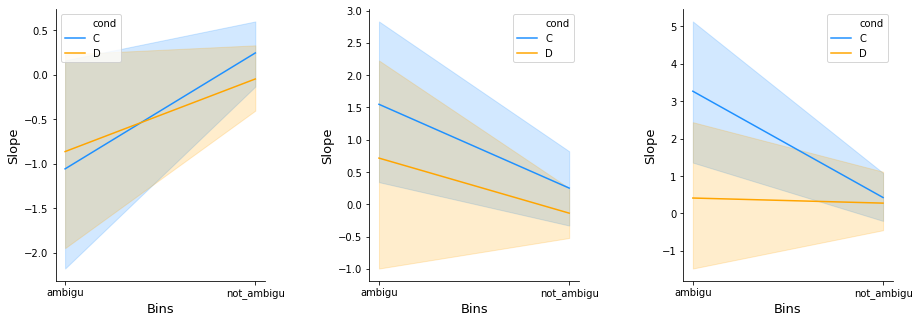

In [90]:
plt.subplots(ncols=3, figsize=(15, 5))
plt.subplots_adjust(wspace = 0.5) #wspace previous 0.5

plt.subplot(1, 3, 1)  #plt.figure(figsize=(2,5))
sns.lineplot(x="bins", y="slope", hue="cond", palette= ["dodgerblue","orange"], 
             data=log_reg_cong_bins.loc[(log_reg_cong_bins.nrep ==0),:])
plt.xlabel('Bins', fontsize= 13)
plt.ylabel('Slope', fontsize= 13)

plt.subplot(1, 3, 2)  #plt.figure(figsize=(2,5))
sns.lineplot(x="bins", y="slope", hue="cond", palette= ["dodgerblue","orange"], 
             data=log_reg_cong_bins.loc[(log_reg_cong_bins.nrep ==1),:])
plt.xlabel('Bins', fontsize= 13)
plt.ylabel('Slope', fontsize= 13)

plt.subplot(1, 3, 3)  #plt.figure(figsize=(2,5))
sns.lineplot(x="bins", y="slope", hue="cond", palette= ["dodgerblue","orange"], 
             data=log_reg_cong_bins.loc[(log_reg_cong_bins.nrep ==2),:])
plt.xlabel('Bins', fontsize= 13)
plt.ylabel('Slope', fontsize= 13)

sns.despine(top=True)

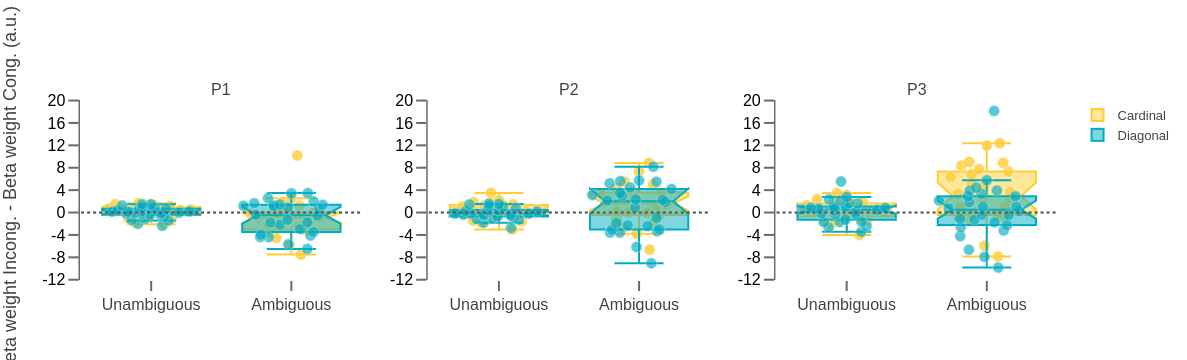

In [91]:
# final step: plot the data
from plotly.subplots import make_subplots
fig = go.Figure()
fig = make_subplots(rows=1, cols=3, subplot_titles=(['P1','P2', 'P3']))
fig.update_yaxes(zeroline=False, zerolinewidth=0, zerolinecolor='Black')

fig.add_shape(type="line", xref="x2", yref="y2", x0=-0.5, y0=0, x1=1.5, y1=0, line=dict(
                color="#595858", width=2.2, dash="dot",))
fig.add_shape(type="line", xref="x3", yref="y3", x0=-0.5, y0=0, x1=1.5, y1=0, line=dict(
                color="#595858", width=2.2, dash="dot",))
fig.add_shape(type="line", xref="x1", yref="y1", x0=-0.5, y0=0, x1=1.5, y1=0, line=dict(
                color="#595858", width=2.2, dash="dot",))

dat = log_reg_cong_bins.loc[(log_reg_cong_bins.cond == 'C') & (log_reg_cong_bins.nrep == 0),:]
fig.add_trace(go.Box(y=dat['slope'], opacity = 0.8, x=dat['bins'], boxpoints='all',
    jitter=.99, # add some jitter for a better separation between points
    pointpos=0,marker=dict(color='#2A88D4',size=11,opacity=0.8,line=dict(color='#f2f2f2', width=.4)),
    notched=True, notchwidth=0.15,
    name='Cardinal', marker_color=' #ffbf00 '), row=1, col=1)

dat = log_reg_cong_bins.loc[(log_reg_cong_bins.cond == 'D') & (log_reg_cong_bins.nrep == 0),:]
fig.add_trace(go.Box(y=dat['slope'], x=dat['bins'], opacity = 1, boxpoints='all',
    jitter=.99, # add some jitter for a better separation between points
    pointpos=0,marker=dict(color='#2A88D4',size=11,opacity=0.65,line=dict(color='#f2f2f2', width=.4)),
    notched=True, notchwidth=0.15,
    name='Diagonal', marker_color=' #00acc1 '), row=1, col=1)

dat = log_reg_cong_bins.loc[(log_reg_cong_bins.cond == 'C') & (log_reg_cong_bins.nrep == 1),:]
fig.add_trace(go.Box(y=dat['slope'], x=dat['bins'], showlegend=False, opacity = 0.8, boxpoints='all',
    jitter=.99, # add some jitter for a better separation between points
    pointpos=0,marker=dict(color='#2A88D4',size=11,opacity=0.8,line=dict(color='#f2f2f2', width=.4)),
    notched=True, notchwidth=0.15, name='Cardinal', marker_color=' #ffbf00 '), row=1, col=2)

dat = log_reg_cong_bins.loc[(log_reg_cong_bins.cond == 'D') & (log_reg_cong_bins.nrep == 1),:]
fig.add_trace(go.Box(y=dat['slope'], x=dat['bins'], boxpoints='all', showlegend=False, opacity = 1,
    jitter=.99, # add some jitter for a better separation between points
    pointpos=0,marker=dict(color='#2A88D4',size=11,opacity=0.65,line=dict(color='#f2f2f2', width=.4)),
    notched=True, notchwidth=0.15,
    name='Diagonal', marker_color=' #00acc1 '), row=1, col=2)

dat = log_reg_cong_bins.loc[(log_reg_cong_bins.cond == 'C') & (log_reg_cong_bins.nrep == 2),:]
fig.add_trace(go.Box(y=dat['slope'], x=dat['bins'], showlegend=False, opacity = 0.8, boxpoints='all',
    jitter=.99, # add some jitter for a better separation between points
    pointpos=0, marker=dict(color='#2A88D4',size=11,opacity=0.8,line=dict(color='#f2f2f2', width=.4)),
    notched=True, notchwidth=0.15,
    name='Cardinal', marker_color=' #ffbf00 '), row=1, col=3)

dat = log_reg_cong_bins.loc[(log_reg_cong_bins.cond == 'D') & (log_reg_cong_bins.nrep == 2),:]
fig.add_trace(go.Box(y=dat['slope'], x=dat['bins'], showlegend=False, opacity = 1, boxpoints='all',
    jitter=.99, # add some jitter for a better separation between points
    pointpos=0,marker=dict(color='#2A88D4',size=11,opacity=0.65,line=dict(color='#f2f2f2', width=.4)),
    notched=True, notchwidth=0.15,
    name='Diagonal', marker_color=' #00acc1 '), row=1, col=3) 

fig.update_layout(boxgroupgap=0)
fig.update_layout(template='plotly_white', xaxis=dict(showgrid=False),
    yaxis=dict(gridcolor='white'))

fig.update_xaxes(showline=False, linewidth=1.5, linecolor='#696969')
fig.update_yaxes(showline=True, linewidth=1.5, linecolor='#696969',
                 tickfont=dict(family='Balto, sans-serif', color='#000000', size=16))
fig.update_xaxes(tickvals = [0, 1], ticktext=['Unambiguous', 'Ambiguous'], 
                 tickangle=0, tickfont=dict(family='Balto, sans-serif', color='#424242', size=16))
fig.update_yaxes(tickvals= [-12,-8, -4, 0, 4, 8, 12, 16, 20], 
                 ticktext=['-12','-8', '-4', '0', '4' ,'8', '12', '16', '20'])
fig.update_yaxes(ticks="outside", tickwidth=2, tickcolor='#696969', ticklen=10)
fig.update_xaxes(ticks="outside", tickwidth=2, tickcolor='#696969', ticklen=10)

fig.update_yaxes(showgrid=False)
fig.update_layout(yaxis_title="Beta weight Incong. - Beta weight Cong. (a.u.)",
    font=dict(family="Balto, sans-serif",size=15, color= "#424242"))

fig.update_layout(
    legend=dict(traceorder="normal", font=dict(family="Balto, sans-serif", size=13, color="#424242")))

fig['layout']['yaxis1'].update(range=[-12.05, 20.1]); fig['layout']['yaxis2'].update(range=[-12.05, 20.1])
fig['layout']['yaxis3'].update(range=[-12.05, 20.1])

fig.show()

<font size="4"> _Statistical tests_

Test whether differences in weight between congruent and incongruent samples with previous decisions depend by the ambiguity of the stimuli sample. 

<font size="2"> _t-test for unambiguous_

In [92]:
# t test for Cardinal, unambiguous & P1
dat = log_reg_cong_bins.loc[(log_reg_cong_bins.cond == 'C') 
                            & (log_reg_cong_bins.bins == 'not_ambigu')
                            & (log_reg_cong_bins.nrep==0),:]

pg.ttest(dat['slope'], 0).round(4)

,T,dof,tail,p-val,CI95%,cohen-d,BF10,power
T-test,1.2429,25,two-sided,0.2254,"[-0.16, 0.64]",0.2438,0.413,0.2231


In [93]:
# t test for Cardinal, unambiguous & P2
dat = log_reg_cong_bins.loc[(log_reg_cong_bins.cond == 'C') 
                            & (log_reg_cong_bins.bins == 'not_ambigu')
                            & (log_reg_cong_bins.nrep==1),:]

pg.ttest(dat['slope'], 0).round(4)

,T,dof,tail,p-val,CI95%,cohen-d,BF10,power
T-test,0.8903,25,two-sided,0.3818,"[-0.33, 0.83]",0.1746,0.297,0.1373


In [94]:
# t test for Cardinal, unambiguous & P3
dat = log_reg_cong_bins.loc[(log_reg_cong_bins.cond == 'C') 
                            & (log_reg_cong_bins.bins == 'not_ambigu')
                            & (log_reg_cong_bins.nrep==2),:]

pg.ttest(dat['slope'], 0).round(4)

,T,dof,tail,p-val,CI95%,cohen-d,BF10,power
T-test,1.2598,25,two-sided,0.2194,"[-0.27, 1.12]",0.2471,0.421,0.2279


In [95]:
# t test for Diagonal, unambiguous & P1
dat = log_reg_cong_bins.loc[(log_reg_cong_bins.cond == 'D') 
                            & (log_reg_cong_bins.bins == 'not_ambigu')
                            & (log_reg_cong_bins.nrep==0),:]

pg.ttest(dat['slope'], 0).round(4)

,T,dof,tail,p-val,CI95%,cohen-d,BF10,power
T-test,-0.2522,25,two-sided,0.8029,"[-0.45, 0.35]",0.0495,0.213,0.0568


In [96]:
# t test for Diagonal, unambiguous & P2
dat = log_reg_cong_bins.loc[(log_reg_cong_bins.cond == 'D') 
                            & (log_reg_cong_bins.bins == 'not_ambigu')
                            & (log_reg_cong_bins.nrep==1),:]

pg.ttest(dat['slope'], 0).round(4)

,T,dof,tail,p-val,CI95%,cohen-d,BF10,power
T-test,-0.6725,25,two-sided,0.5074,"[-0.55, 0.28]",0.1319,0.255,0.0992


In [97]:
# t test for Diagonal, unambiguous & P3
dat = log_reg_cong_bins.loc[(log_reg_cong_bins.cond == 'D') 
                            & (log_reg_cong_bins.bins == 'not_ambigu')
                            & (log_reg_cong_bins.nrep==2),:]

pg.ttest(dat['slope'], 0).round(4)

,T,dof,tail,p-val,CI95%,cohen-d,BF10,power
T-test,0.731,25,two-sided,0.4716,"[-0.5, 1.05]",0.1434,0.264,0.1083


<font size="2"> _t-test for ambiguous_

In [98]:
# t test for Cardinal, ambiguous & P1
dat = log_reg_cong_bins.loc[(log_reg_cong_bins.cond == 'C') 
                            & (log_reg_cong_bins.bins == 'ambigu')
                            & (log_reg_cong_bins.nrep==0),:]

pg.ttest(dat['slope'], 0).round(4)

,T,dof,tail,p-val,CI95%,cohen-d,BF10,power
T-test,-1.6617,25,two-sided,0.1091,"[-2.37, 0.25]",0.3259,0.693,0.3589


In [99]:
# t test for Cardinal, ambiguous & P2
dat = log_reg_cong_bins.loc[(log_reg_cong_bins.cond == 'C') 
                            & (log_reg_cong_bins.bins == 'ambigu')
                            & (log_reg_cong_bins.nrep==1),:]

pg.ttest(dat['slope'], 0).round(4)

,T,dof,tail,p-val,CI95%,cohen-d,BF10,power
T-test,2.2758,25,two-sided,0.0317,"[0.15, 2.95]",0.4463,1.819,0.5902


In [100]:
# t test for Cardinal, ambiguous & P3
dat = log_reg_cong_bins.loc[(log_reg_cong_bins.cond == 'C') 
                            & (log_reg_cong_bins.bins == 'ambigu')
                            & (log_reg_cong_bins.nrep == 2),:]

pg.ttest(dat['slope'], 0).round(4)

,T,dof,tail,p-val,CI95%,cohen-d,BF10,power
T-test,3.2932,25,two-sided,0.003,"[1.22, 5.31]",0.6459,13.372,0.8858


In [101]:
# t test for Diagonal, ambiguous & P1
dat = log_reg_cong_bins.loc[(log_reg_cong_bins.cond == 'D') 
                            & (log_reg_cong_bins.bins == 'ambigu')
                            & (log_reg_cong_bins.nrep==0),:]

pg.ttest(dat['slope'], 0).round(4)

,T,dof,tail,p-val,CI95%,cohen-d,BF10,power
T-test,-1.5317,25,two-sided,0.1381,"[-2.02, 0.3]",0.3004,0.582,0.3135


In [102]:
# t test for Diagonal, ambiguous & P2
dat = log_reg_cong_bins.loc[(log_reg_cong_bins.cond == 'D') 
                            & (log_reg_cong_bins.bins == 'ambigu')
                            & (log_reg_cong_bins.nrep==1),:]

pg.ttest(dat['slope'], 0).round(4)

,T,dof,tail,p-val,CI95%,cohen-d,BF10,power
T-test,0.8562,25,two-sided,0.4,"[-1.01, 2.44]",0.1679,0.289,0.1306


In [103]:
# t test for Diagonal, ambiguous & P3
dat = log_reg_cong_bins.loc[(log_reg_cong_bins.cond == 'D') 
                            & (log_reg_cong_bins.bins == 'ambigu')
                            & (log_reg_cong_bins.nrep==2),:]

pg.ttest(dat['slope'], 0).round(4)

,T,dof,tail,p-val,CI95%,cohen-d,BF10,power
T-test,0.398,25,two-sided,0.694,"[-1.72, 2.55]",0.0781,0.223,0.067


Post-hoc t-test: one chunck for each presentation

In [104]:
# post-hoc t-test for P1
pg.pairwise_ttests(dv='slope', within=['bins', 'cond'], subject='npar', padjust='bonf', 
                   effsize = 'cohen', interaction=True, 
                   data=log_reg_cong_bins.loc[log_reg_cong_bins.nrep==0]) 

,Contrast,bins,A,B,Paired,Parametric,T,dof,Tail,p-unc,p-corr,p-adjust,BF10,cohen
0,bins,-,not_ambigu,ambigu,True,True,3.662612,25.0,two-sided,0.001172,NaN,NaN,29.917,0.847750
1,cond,-,C,D,True,True,0.095074,25.0,two-sided,0.925014,NaN,NaN,0.208,0.029604
2,bins * cond,not_ambigu,C,D,True,True,1.123136,25.0,two-sided,0.272050,0.544101,bonf,0.365,0.293154
3,bins * cond,ambigu,C,D,True,True,-0.189045,25.0,two-sided,0.851584,1.000000,bonf,0.211,-0.063258


In [105]:
# post-hoc t-test for P2
pg.pairwise_ttests(dv='slope', within=['bins', 'cond'], subject='npar', padjust='bonf', 
                   effsize = 'cohen', interaction=True, 
                   data=log_reg_cong_bins.loc[log_reg_cong_bins.nrep==1]) 

,Contrast,bins,A,B,Paired,Parametric,T,dof,Tail,p-unc,p-corr,p-adjust,BF10,cohen
0,bins,-,not_ambigu,ambigu,True,True,-2.093122,25.0,two-sided,0.046646,NaN,NaN,1.334,-0.550357
1,cond,-,C,D,True,True,1.025191,25.0,two-sided,0.315091,NaN,NaN,0.333,0.290866
2,bins * cond,not_ambigu,C,D,True,True,1.068622,25.0,two-sided,0.295450,0.590901,bonf,0.347,0.309386
3,bins * cond,ambigu,C,D,True,True,0.741926,25.0,two-sided,0.465046,0.930092,bonf,0.266,0.214317


In [106]:
# post-hoc t-test for P3
pg.pairwise_ttests(dv='slope', within=['bins', 'cond'], subject='npar', padjust='bonf', 
                   effsize = 'cohen', interaction=True, 
                   data=log_reg_cong_bins.loc[log_reg_cong_bins.nrep==2]) 

,Contrast,bins,A,B,Paired,Parametric,T,dof,Tail,p-unc,p-corr,p-adjust,BF10,cohen
0,bins,-,not_ambigu,ambigu,True,True,-2.245352,25.0,two-sided,0.033832,NaN,NaN,1.725,-0.659875
1,cond,-,C,D,True,True,1.556510,25.0,two-sided,0.132157,NaN,NaN,0.602,0.521835
2,bins * cond,not_ambigu,C,D,True,True,0.333949,25.0,two-sided,0.741203,1.000000,bonf,0.218,0.081805
3,bins * cond,ambigu,C,D,True,True,1.686901,25.0,two-sided,0.104063,0.208126,bonf,0.718,0.551901
